## Original data exploration and cleaning

Utrecht University, Applied Data Science, Master thesis

By Sander Engelberts (1422138)

May-June 2022

This notebook is used to inspect and clean the original data sets of CBG personal record cards and passport requests. This ensures that more place entities can be retrieved from linked open data sources, and features and their missing values are standardised. After cleaning, the data is also further explored with regards to frequency balances of features. 

In [1]:
# Import required packages
import os # for paths to files in operating system
import openpyxl # for loading Excel documents
import pandas as pd # for dataframes and operations on it
import datetime # for representing dates in a standardised format
from tqdm import tqdm # for displaying progress of operations
import numpy as np # for mathematical operations and missing values (np.nan)
import matplotlib.pyplot as plt # for plotting
import missingno as msno # for visualising missingness patterns in data
import re # for regular expressions on strings

tqdm.pandas() # display progress of pandas operations such as apply (use progress_apply instead)

## Inspect and clean original CBG personal record cards

This is the original set of personal record cards of which the recorded part of the meta data is checked via VeleHanden.nl and hence fully corresponds to the information recorded on its respective document. This data got exported on 10th of May 2022 and may at a later moment get extended with the newer checked personal record cards to fill in the now missing values. In the future also more of the features may get digitized. 

In [2]:
# Path to folder where I stored the data, so adjust to own storage location
data_path = "E:\CBG" 

# Path to personal record cards data
person_card_path = os.path.join(data_path, "persoonskaarten_10-05-2022.csv")

In [3]:
# Load personal record cards data into a dataframe
df_person_card = pd.read_csv(person_card_path, sep=",", header=0, index_col=None)

In [4]:
# Inspect personal record cards data
df_person_card.columns

Index(['uuid', 'Bestandsnaam CBG', 'Doosnummer', 'Achternaam', 'Voornaam',
       'Geboortedatum', 'Geboorteplaats', 'Onderdeel'],
      dtype='object')

These translation/description of these columns is:
* 'uuid' : unique identifier of personal record card at CBG
* 'Bestandsnaam CBG' : unique identifier of the digital personal record card at CBG 
* 'Doosnummer' : number of the box in which the physical personal record card is stored in the CBG archives
* 'Achternaam' : last name of key person
* 'Voornaam' : first name of key person
* 'Geboortedatum' : birth date in YYYY-MM-DD format
* 'Geboorteplaats' : birth place name
* 'Onderdeel' : additional information recorded on the personal record card, often a further specification of 'Geboorteplaats' it seems with inspection

In [ ]:
# Inspect personal record cards data
# Output cleared due to privacy-sensitive data
df_person_card.head()

In the snippet above can be seen that all personal record cards are contained within the dataset, but only the checked ones have values for the person attributes.

In [6]:
print("The original personal record card data contains", len(df_person_card), "records")

The original person card data contains  4120553  records


In [7]:
# Subset the data to only keep the records that contain at least one feature with noted meta data
df_person_card = df_person_card.dropna(axis=0, how='all', 
                                       subset=['Achternaam', 'Voornaam', 
                                               'Geboortedatum', 'Geboorteplaats'])

In [ ]:
# Inspect subsetted personal record card data
# Output cleared due to privacy-sensitive data
df_person_card.head()

In [9]:
print("The subsetted personal record card data contains", len(df_person_card), "records")

The subsetted person card data contains  1256801  records


In [10]:
# Check how many missing values are remained in the columns
df_person_card.isna().sum()

uuid                      0
Bestandsnaam CBG          0
Doosnummer                0
Achternaam              632
Voornaam                630
Geboortedatum             0
Geboorteplaats            1
Onderdeel           1113909
dtype: int64

In [11]:
# Check types of columns
df_person_card.dtypes

uuid                object
Bestandsnaam CBG    object
Doosnummer          object
Achternaam          object
Voornaam            object
Geboortedatum       object
Geboorteplaats      object
Onderdeel           object
dtype: object

In [ ]:
# Check what the 'Onderdeel' (component) column contains when it does not include a missing value
# It seems to be a further specification of 'Geboorteplaats' (birth place) and hence can help
# finding the place name URI when needed
# Output cleared due to privacy-sensitive data
df_person_card[~df_person_card.Onderdeel.isna()].head()

In [13]:
# Check number of unique values in each column
df_person_card.nunique()

uuid                1256801
Bestandsnaam CBG    1256801
Doosnummer             1559
Achternaam            66999
Voornaam             216895
Geboortedatum         50027
Geboorteplaats        21137
Onderdeel              3560
dtype: int64

In [14]:
def convert_to_datetime(date_str, sep='-'):
    '''
    From a date string in order YYYY:MM:DD create a datetime.date object
    
    Parameters
    ----------    
    date_str: str
        String representing a date in order YYYY:MM:DD
    sep : string (default '-')
        Separator dividing the separate date components
        
    Returns
    -------
    date : datetime.date object or string
        Date object in case of no missing date elements, else if some are missing a
        string in YYYY-MM-DD format is returned with zeroes as placeholders for missing 
        elements, else a missing value is returned
    '''
    # Check if date string is too short or long (should be 8 characters plus separators)
    # In that case date format cannot be assumed (e.g. not full 4 digit year written out)
    if len(date_str) < 8+2*len(sep) or len(date_str) > 8+2*len(sep):
        date = date_str # Just return the date string instead of datetime.date object
    elif date_str == '0000'+sep+'00'+sep+'00':
        # Completely missing value is recorded as 0000-00-00 in personal record cards 
        # so exchange with NaN
        date = np.nan 
    else:
        if sep is not '':
            # String with separator (e.g. YYYY-MM-DD)
            date_lst = date_str.split(sep)
        else:
            # String without separators in YYYYMMDD format
            date_lst = [date_str[0:4], date_str[4:6], date_str[6:8]]  
        try:
            # Convert date string into datetime.date object
            date = datetime.date(year=int(date_lst[0]), month=int(date_lst[1]), 
                                 day=int(date_lst[2]))
        except:
            # Sometimes part of date is missing value, e.g. in personal record cards 1930-00-00
            # Then some information is still recorded, so interesting to keep the string 
            # However, still record date in a standard format for which the string can easily
            # be split on '-' to get the year, month and day separately (with missing value
            # being as many zeroes as the date part should contain)
            date = '-'.join(date_lst)
    return date

In [15]:
# Replace dates for datetime objects
df_person_card.Geboortedatum = df_person_card.Geboortedatum.progress_apply(
    lambda x: convert_to_datetime(date_str=x, sep='-'))

100%|████████████████████████████████████████████████████████████████████| 1256801/1256801 [00:03<00:00, 325877.62it/s]


In [16]:
# Check number of missing dates now the fully missing values are replaced by missing values
df_person_card.Geboortedatum.isna().sum()

229

In [17]:
# Check number of dates that couldn't get converted into a datetime.date object
# This is likely due to partially missing values (e.g. missing month and/or day)
df_person_card.Geboortedatum.progress_apply(lambda x: isinstance(x, str)).sum() 

100%|████████████████████████████████████████████████████████████████████| 1256801/1256801 [00:01<00:00, 985542.28it/s]


914

In [ ]:
# Inspect records with partially missing values
# Output cleared due to privacy-sensitive data
df_person_card[df_person_card.Geboortedatum.progress_apply(lambda x: isinstance(x, str))].head()

In [19]:
# Create dictionary with Dutch province abbreviations and (non-standardised) full names
# in regular expressions as keys and as values a standardised province name
# Abbreviations firstly from (note that Flevoland is missing): 
# https://cbg.nl/documents/12/Nationaal_Register_Overledenen_persoonskaarten_en_persoonslijsten.pdf
# Additionally, if different, suffixes of ISO codes of Dutch provinces were added 
# (including Flevoland) from: https://www.iso.org/obp/ui/#iso:code:3166:NL
# A few additional found variants seen in data were added as well
# To allow for any upper or lower casing (as used in the data), use re.IGNORECASE
# E.g. DR? means matching on D and DR, N[ |\-]?Br? matches NB, NBr, N B, N Br, N-B, and N-Br,
# and G(?:E|eld|l|ld)? on G, GE, Geld, Gl, and Gld
# Note that for Utrecht and Groningen the full name matching is removed in keys as these also
# have a city with the same name which could otherwise be mistaken as province name
# Make sure to first match on first case-sensitive Ut as that is abbreviation for the city,
# and only after see if also province abbreviation is added as well.
province_abbreviations = {r'\bDR?\b|\bDrenthe\b':'Drenthe', 
                          r'\bFR?\b|\bFriesland\b':'Friesland', 
                          r'\bG(?:E|eld|l|ld)?\b|\bGelderland\b':'Gelderland', 
                          r'\bGr\b':'Groningen',
                          r'\bL[I|B]?\b|\bLimburg\b':'Limburg', 
                          r'\bN[ |\-]?Br?\b|\bNoord[ |\-]?Brabant\b':'Noord-Brabant', 
                          r'\bN[ |\-]?H\b|\bNoord[ |\-]?Holland\b':'Noord-Holland', 
                          r'\bOV?\b|\bOverijssel\b':'Overijssel', 
                          r'\bUT?\b':'Utrecht',  
                          r'\bZ[ |\-]?H\b|\bZuid[ |\-]?Holland\b':'Zuid-Holland',
                          r'\bZE?\b|\bZeeland\b':'Zeeland',
                          r'\bFL\b|\bFlevoland\b':'Flevoland'}

In [20]:
def separate_place_province(place_lst, province_abbreviations):
    '''
    Remove Dutch province abbreviations from list of birth places and return lists 
    retrieved place and full province name. This can also be applied for other similar 
    abbreviation dictionaries such as country names
    
    This way multiple combinations of place strings can better be queried in ErfGeo and Wikidata,
    because the non-cleaned place name variants may not exist within these LOD sources
    
    Parameters
    ----------
    place_lst: list or Pandas Series
        List containing place names with potential province indicators
    province_abbreviations: dictionary
        Dictionary with (Dutch) province abbreviations variants keys as regular expression 
        and their full standardised names as values. This can also be a different dictionary
        with for example country name abbreviations
    
    Returns
    -------
    new_places : list of strings
        Cleaned place_lst without Dutch province indicators in place names
    provinces : list of strings
        List with full standardised province (or country) names that were retrieved
        from the place_lst place names
    '''
    # Create empty lists for results
    new_places = []
    provinces = []

    # Create a list from the province abbreviations keys such that these can be indexed 
    # instead of needing to always check for each province 
    province_keys_lst = list(province_abbreviations.keys())
    # Number of provinces to check
    n_province = len(province_keys_lst)

    # Check for province indicators in each place name
    for place in tqdm(place_lst, total = len(place_lst)):
        # Check if place is not a missing value
        if not pd.isna(place) and place != '':
            # Create boolean for the early stopping condition of only finding a
            # province result (a place should not belong to multiple provinces so
            # can't expect multiple province abbreviations in a single place string)
            province_found = False
            index = 0 # Index to not have to loop through all provinces but early stop
            
            # Check for each province abbreviation if it is contained in this place string,
            # and stop early when one is found or all provinces are checked
            while not province_found and index < n_province:
                # Retrieve the next province's regular expression key
                province_regexp = province_keys_lst[index]
                
                # Loop through province abbreviations (until one found) 
                # and retrieve a potentially corresponding province
                # Use case-insensitive matching such that different capitalization won't 
                # influence matching of Dutch province names/abbreviations
                province = re.search(province_regexp, place, re.IGNORECASE)
                
                # If a province abbreviation is found, then stop early,
                # else check for a next one
                if province is not None:
                    # Retrieve the found province abbreviation from re.Match object 
                    province = province.group()
                    
                    # Set province_found to True
                    province_found = True
                else:
                    # Increase index to get a next province
                    index += 1
                
            # If no province indicator found, then make it a missing value 
            if not province_found:
                new_place_str = place
                province_str = np.nan
            else:
                # Remove the found province abbreviation from place string
                new_place_str = re.sub(r'\b'+province+r'\b', '', place)
                
                # Replace the province abbreviation for its standardised name
                province_str = province_abbreviations[province_regexp]            
        else:
            # Retain the missing value if place string was already missing
            new_place_str = np.nan
            province_str = np.nan
        
        # Remove potential additional spaces in place string
        # (province string is already the standardised name, no other symbols)
        if new_place_str is not np.nan:
            # Remove potential additional spaces at the beginning or end of the string
            new_place_str = new_place_str.strip()
            # Remove additional spaces within string (so e.g. 2 consecutive spaces become 1),
            new_place_str = re.sub(' +', ' ', new_place_str)
        
        # Add found results to lists
        new_places.append(new_place_str)
        provinces.append(province_str)
    
    return new_places, provinces

In [21]:
def remove_parentheses(string):
    """
    Clean string from text between parentheses
    
    This function is a duplicate from Data_exploration.ipybn
    
    Parameters
    ----------
    string : string
        Text string that potentially contains additional text within parentheses
        
    Returns
    -------
    string : string
        Cleaned text without parentheses_text information
    parentheses_text : string
        Text that was written within parentheses in the input string
    """
    # Find the parts of the string that are within parentheses (including the brackets)
    # Note that this does not work for nested parentheses, but these are not expected for 
    # this data
    parentheses_text = re.findall('\(.*?\)', string)

    # Remove the potential texts within parentheses from the string
    for text in parentheses_text:
        string = string.replace(text, "")
        
    # Remove the parentheses from the texts that are between these
    parentheses_text = [text.replace('(', "").replace(')', "") for text in parentheses_text]

    # If no texts within parentheses are found, then record a missing value,
    # if one is found then its string, and else the join the multiple strings
    # that were within multiple parentheses
    if len(parentheses_text) == 0:
        parentheses_text = np.nan
    elif len(parentheses_text) == 1:
        parentheses_text = parentheses_text[0]
    else:
        parentheses_text = " ".join(parentheses_text)
        
    return string, parentheses_text

In [22]:
# Standard place and country abbreviations used in personal record cards from 
# https://cbg.nl/documents/12/Nationaal_Register_Overledenen_persoonskaarten_en_persoonslijsten.pdf
place_abbreviations = {'a/d L':'aan de Lek', 'a/d R':'aan den Rijn', 'a/d IJ':'aan den IJssel',
                       'a/Z':'aan Zee', 'Ah':'Arnhem', 'Ap':'Apeldoorn', 'Asd':'Amsterdam', 
                       'Bd':'Breda', "'s Bosch":"'s-Hertogenbosch", 'Dordt':'Dordrecht', 
                       'Ehv':'Eindhoven', 'Esd':'Enschede', 'Gron':'Groningen',
                       'Gv':"'s-Gravenhage", 'Hlm':'Haarlem', 'Hvs':'Hilversum', 'Ledn':'Leiden', 
                       'Mt':'Maastricht', 'Nmg':'Nijmegen', 'Rt':'Rotterdam', 'St.':'Sint', 
                       'St':'Sint', 'Tb':'Tilburg',  'Ut':'Utrecht', 'Zst':'Zaanstad'}

# Regular expression keys to find abbreviations of country names or their Dutch and English 
# variants (if not a country that doesn't exist anymore in that form or belongs to a long 
# country name that would not likely be fully used in English (nor Dutch)),
# which have a standardised full Dutch name as value
# Note: (?:abc)? matches nothing or the string abc, and if one of these is nested then that 
# is added again to the back of the word with likely two options separated by |. 
# Further, [a|b] has option a or b, but wouldn't match full substring like abc 
# specified with (?:abc)
# Note that abbreviation NL is added for the Netherlands
# Note: there are countries newer than the personal record cards these abbreviations are based on,
# as well as additional countries, but these are not considered as in that time of the datasets
# this is unlikely to have been recorded on personal documents
country_abbreviations = {r'\bAfg(?:hanistan)?\b':'Afghanistan', 
                         r'\bAlg(?:eri(?:a|je))?\b':'Algerije', 
                         r'\bArg(?:entini[a|ë])?\b':'Argentinië',
                         r'\bAus(?:trali[a|ë])?\b':'Australië', 
                         r'\bBe(?:lgi(?:um|ë))?\b':'België', 
                         r'\bBol(?:ivia)?\b':'Bolivia', 
                         r'\bBra(?:zil(?:ië)?)?\b':'Brazilië', 
                         r'\bBRD|Bondsrepubliek[ |\-]?Duitsland\b':'Bondsrepubliek Duitsland', 
                         r'\bBul(?:gari(?:a|je))?\b':'Bulgarije', 
                         r'\bCan(?:ada)?\b':'Canada', 
                         r'\bChin[a]?\b':'China', 
                         r'\bCo(?:lombia)?\b':'Colombia', 
                         r'\bDDR|Duitse[ |\-]?Democratische[ |\-]?Republiek\b':
                         'Duitse Democratische Republiek', 
                         r'\bDen(?:emarken)?|Danmark\b':'Denemarken', 
                         r'\bDl|Duitsland|Germany\b':'Duitsland', 
                         r'\bEth(?:iopi[a|ë])?\b':'Ethiopië', 
                         r'\bFin(?:land)?\b':'Finland', 
                         r'\bFr(?:an(?:krijk|ce))?\b':'Frankrijk', 
                         r'\bGB|Great[ |\-]?Britain|Verenigd[ |\-]?Koninkrijk\b':
                         'Verenigd Koninkrijk', 
                         r'\bGuat(?:emala)?\b':'Guatemala', 
                         r'\bHon(?:gar(?:y|ije))?\b':'Hongarije', 
                         r'\bHond(?:uras)?\b':'Honduras', 
                         r'\bIer(?:land)?|Ireland\b':'Ierland', 
                         r'\bIndon(?:esi[a|ë])?\b':'Indonesië', 
                         r'\bIsr(?:a[e|ë]l)?\b':'Israël', 
                         r'\bIt(?:al(?:y|ië))?\b':'Italië', 
                         r'\bJap(?:an)?\b':'Japan', 
                         r'\bJem(?:en)?\b':'Jemen', 
                         r'\bJS|Joegoslavië|Yugoslavia\b':'Joegoslavië', 
                         r'\bKon(?:go)?\b':'Kongo', 
                         r'\bKor(?:ea)?\b':'Korea', 
                         r'\bLib(?:eria)?\b':'Liberia', 
                         r'\bLux(?:emb[o]?urg)?\b':'Luxemburg',  
                         r'\bMalei(?:si[a|ë])?\b':'Maleisië', 
                         r'\bMar(?:o(?:cc|kk)o)?\b':'Marokko', 
                         r'\bMex(?:ico)?\b':'Mexico', 
                         r'\bMon(?:aco)?\b':'Monaco', 
                         r'\bNA|Ne(?:derlandse|therlands)[ |\-]?Antille[n|s]\b':
                         'Nederlandse Antillen',
                         r'\bNic(?:aragua)?\b':'Nicaragua', 
                         r'\b(?:the[ |\-]?)?N(?:L|ederland|etherlands)|Holland\b':'Nederland', 
                         r'\bNo(?:o(?:orwegen|rway))?\b':'Noorwegen', 
                         r'\bNZ|Nieuw[ |\-]?Zeeland|New[ |\-]?Zealand\b':'Nieuw-Zeeland', 
                         r'\bOos(?:tenrijk)?|Austria\b':'Oostenrijk', 
                         r'\bPak(?:istan)?\b':'Pakistan', 
                         r'\bPan(?:ama)?\b':'Panama', 
                         r'\bPar(?:aguay)?\b':'Paraguay', 
                         r'\bPol(?:en|and)?\b':'Polen', 
                         r'\bPor(?:tugal)?\b':'Portugal', 
                         r'\bRhod(?:esi[a|ë])?\b':'Rhodesië', 
                         r'\bRoem(?:eni[a|ë])?\b':'Roemenië', 
                         r'\bSaA|Saoedi[ |\-]?Arabi[a|ë]\b':'Saoedi-Arabië', 
                         r'\bSAR|Syri[a|ë]\b':'Syrië', 
                         r'\bSen(?:egal)?\b':'Senegal', 
                         r'\bSing(?:apore)?\b':'Singapore', 
                         r'\bSoe(?:dan)?\b':'Soedan', 
                         r'\bSom(?:ali[a|ë])?\b':'Somalië', 
                         r'\bSp(?:a(?:in|nje))?\b':'Spanje', 
                         r'\bSur(?:iname)?\b':'Suriname',  
                         r'\bTan(?:zania)?\b':'Tanzania', 
                         r'\bThai(?:land)?\b':'Thailand', 
                         r'\bTsjs|Tsjechoslowakije|Czechoslovakia\b':'Tsjechoslowakije', 
                         r'\bTun(?:esi[a|ë])?\b':'Tunesië', 
                         r'\bTur(?:k(?:ey|ije))?\b':'Turkije', 
                         r'\bUr(?:uguay)?\b':'Uruguay', 
                         r'\bUSSR|So(?:wj|vi)et[ |\-]?Uni(?:e|on)\b':'Sowjet Unie', 
                         r'\bVAR|Verenigde[ |\-]?Arabische[ |\-]?Republiek\b':
                         'Verenigde Arabische Republiek', 
                         r'\bVat(?:ica(?:n[ |\-]?city|anstad))?\b':'Vaticaanstad', 
                         r'\bVen(?:ezuela)?\b':'Venezuela', 
                         r'\bViet(?:nam)?\b':'Vietnam', 
                         r'\bVSA|Verenigde[ |\-]?Staten[ |\-]?van[ |\-]?Ameri[k|c]a\b':
                         'Verenigde Staten van Amerika', 
                         r'\bIjs(?:land)?|Iceland\b':'Ijsland', 
                         r'\bZAf|(?:Zuid|South)[ |\-]?Afri[k|c]a\b':'Zuid-Afrika', 
                         r'\bZam(?:bia)?\b':'Zambia',
                         r'\bZwed(?:en)?\b':'Zweden', 
                         r'\bZwit(?:serland)?|Switzerland\b':'Zwitserland'
                        } 

In [23]:
def replace_abbreviations(string, place_abbreviations):
    '''
    Replace abbreviations of places with full standardised words, from: 
    https://cbg.nl/documents/12/Nationaal_Register_Overledenen_persoonskaarten_en_persoonslijsten.pdf
    
    Parameters
    ----------
    string : string
        Place name string that potentially has common place abbreviations
    place_abbreviations: dictionary
        Dictionary with place abbreviations variants keys as regular expression 
        and their full standardised names as values
    
    Returns
    -------
    string : string
        Place name string that does have the common place abbreviations written out fully
    '''
    # Loop through all abbreviations and replace them with their corresponding full string
    # if this abbreviation is found within the place name string
    for abbreviation in place_abbreviations.keys():
        string = re.sub(r'\b'+str(abbreviation)+r'\b', place_abbreviations[abbreviation], string)
    
    return string

In [28]:
def clean_place_names(df_places, place_abbreviations):
    '''
    Clean place names from common occuring additions or symbols,
    of which informative information can be stored in separate columns
    
    Parameters
    ----------
    df_places : Pandas dataframe or list of strings
        List containing place names that need to be cleaned
    place_abbreviations : dictionary
        Dictionary with place abbreviations variants keys as regular expression 
        and their full standardised names as values
    
    Returns
    -------
    new_places : list of strings
        Cleaned df_places without common occuring additions or symbols
    additional_info : list of strings
        List with found additional information that were cleaned from df_places
    ''' 
    # Create lists to store results in
    new_places = []
    additional_info = [] 
    
    # Clean each place name in df_places
    for place_str in tqdm(df_places, total=len(df_places)):
        # Check if place is not a missing value
        if not pd.isna(place_str) and place_str != '':
            # Sometimes is referred to another part of a document in multiple ways
            # with 'zie' or 'zie vak', which need to get removed (any upper or lower case allowed)
            place_str = re.sub(r'\bzie|z|vak|v\b', '', place_str, re.IGNORECASE)

            # Remove digits from place name (this is the case if referred to another 
            # part on document)
            place_str = re.sub(r'\d+', '', place_str)

            # Replace known place abbreviations
            place_str = replace_abbreviations(string=place_str, 
                                              place_abbreviations=place_abbreviations)

            # Replace odd symbols
            # _ for space
            place_str = place_str.replace('_', ' ')
            # & sign for Dutch 'en' (in English: and)
            place_str = place_str.replace('&', ' en ')
            # c.a. (circa) remove (just says someone lived around that place)
            place_str = re.sub(r'\Wc\.a\.\W?', '', place_str)

            # Separate place name from additional parts within parentheses
            place_str, parentheses_text = remove_parentheses(string=place_str)

            # Remove symbols when just one parenthesis was added (so no parentheses_text found)
            place_str = place_str.replace('(', ' ').replace(')', ' ')

            # Remove potential additional spaces at the beginning or end of the string
            place_str = place_str.strip()
            if parentheses_text is not np.nan:
                parentheses_text = parentheses_text.strip()

            # Remove additional spaces within string (so e.g. 2 consecutive spaces become 1),
            place_str = re.sub(' +', ' ', place_str)
            if parentheses_text is not np.nan:
                parentheses_text = re.sub(' +', ' ', parentheses_text)
                
        else:
            # Retain the missing value if place string was already missing
            place_str = np.nan
            parentheses_text = np.nan

        # Add cleaned strings to lists
        new_places.append(place_str)
        additional_info.append(parentheses_text)
        
    return new_places, additional_info

In [25]:
def merge_lists(list_1, list_2):
    '''
    Merge lists with similar features while considering that one or both may have missing
    values or (not) the same ones. Useful for merging the results of place and province/country
    separation when this is done on partially cleaned place strings and the information that
    was mentioned within parentheses so can both potentially retrieve such province/country
    indicators
    
    Parameters
    ----------
    list_1 : list of strings
        List with strings that should be merged with list_2
    list_2 : list of strings
        List with strings that should be merged with list_1

    Returns
    -------
    merged_lst : list of strings
        List with strings that is an aggregated combination of information in list_1 and list_2
    '''
    # Create empty list for storing results
    merged_lst = []
    
    # Merge e.g. Dutch provinces found in cleaned place names and ones found in 
    # added information between parentheses (likely none are found or only within one 
    # of the two parts, but else they will be added together if the found provinces aren't equal)
    # For this loop through each item in both lists in a zipped way
    for item1, item2 in zip(list_1, list_2):
        if pd.isna(item1) and pd.isna(item2):
            # Both items are missing values, then remain a missing value
            merged_lst.append(np.nan)
        elif pd.isna(item1):
            # item1 is a missing value, then keep the value of item2
            merged_lst.append(item2)
        elif pd.isna(item2):
            # item2 is a missing value, then keep the value of item1
            merged_lst.append(item1)
        elif item1 == item2:
            # If both items equal, then keep just one copy of it
            merged_lst.append(item1)
        else:
            # If both items are different and non-missing, concatenate them into a single string
            merged_lst.append(item1+', '+item2)
    
    return merged_lst

In [26]:
def clean_separate_place_province(df_places, province_abbreviations,
                                 place_abbreviations, country_abbreviations):
    '''
    Runs clean_place_names and separate_place_province functions and results in
    four new feature lists: cleaned birth place name, Dutch birth province name, country name, 
    and other additional text from within parentheses (e.g. province in other country)
    
    Parameters
    ----------
    df_places : Pandas dataframe or list of strings
        List containing place names that need to be cleaned
    province_abbreviations: dictionary
        Dictionary with (Dutch) province abbreviations variants keys as regular expression 
        and their full standardised names as values
    place_abbreviations : dictionary
        Dictionary with place abbreviations variants keys as regular expression 
        and their full standardised names as values
    country_abbreviations: dictionary
        Dictionary with country abbreviations variants keys as regular expression 
        and their full standardised Dutch names as values
        
    Returns
    -------
    new_places : list of strings
        Cleaned df_places without common occuring additions or symbols, with province and
        country indicators removed, and place abbreviations written out fully
    additional_info : list of strings
        List with text that was written between parentheses but not a cleaned out addition/ 
        symbol nor a province or country indicator
    provinces : list of strings
        List with full standardised province names that were retrieved
        from the df_places place names (possibly within text in added parentheses)
    countries : list of strings
        List with full standardised country names that were retrieved
        from the df_places place names (possibly within text in added parentheses)
    '''
    # Clean place names from symbols and added information within parentheses
    new_places, additional_info = clean_place_names(df_places=df_places,
                                                   place_abbreviations=place_abbreviations)
      
    # Check if cleaned place name has Dutch province indicator
    new_places, provinces_1 = separate_place_province(place_lst=new_places, 
                                        province_abbreviations=province_abbreviations)
    
    # Check if there was Dutch province information between added parentheses
    additional_info, provinces_2 = separate_place_province(place_lst=additional_info, 
                                        province_abbreviations=province_abbreviations)
    
    # Merge Dutch provinces found in cleaned place names and added information between
    # parentheses (likely none are found or only within one of the two parts, but else
    # they will be added together if the found provinces aren't equal)
    provinces = merge_lists(list_1=provinces_1, list_2=provinces_2)
    
    # Add standardised name for the Netherlands when Dutch province was found as that
    # indicates this is the case
    country_0 = ['Nederland' if province is not np.nan else np.nan for province in provinces]
    
    # Check if cleaned place name has country indicator
    new_places, country_1 = separate_place_province(place_lst=new_places, 
                                        province_abbreviations=country_abbreviations)
    
    # Merge inferred Netherlands country name from provinces, with ones found in cleaned place
    # names
    countries = merge_lists(list_1=country_0, list_2=country_1)
    
    # Check if there was country information between added parentheses
    additional_info, country_2 = separate_place_province(place_lst=additional_info, 
                                        province_abbreviations=country_abbreviations)
    
    # Merge countries found in cleaned place names and added information between
    # parentheses (likely none are found or only within one of the two parts, but else
    # they will be added together if the found countries aren't equal) 
    countries = merge_lists(list_1=countries, list_2=country_2)
    
    return new_places, additional_info, provinces, countries 

In [29]:
# Clean place names and separate these from province and country indicators or added info
# between parentheses, and replace abbreviations for full names
place_person_card, extra_person_card, province_person_card, country_person_card = \
clean_separate_place_province(
    df_places=df_person_card.Geboorteplaats, 
    province_abbreviations=province_abbreviations, 
    place_abbreviations=place_abbreviations,
    country_abbreviations=country_abbreviations)

100%|████████████████████████████████████████████████████████████████████| 1256801/1256801 [00:01<00:00, 964514.15it/s]


In [30]:
# Add column with full province names
df_person_card['Geboorteprovincie'] = province_person_card

In [31]:
# Check if Onderdeel column with some random added information has country indicator
# (when inspecting there were some)
new_onderdeel, onderdeel_country = separate_place_province(place_lst=df_person_card.Onderdeel, 
                                        province_abbreviations=country_abbreviations)

100%|█████████████████████████████████████████████████████████████████████| 1256801/1256801 [00:14<00:00, 85364.13it/s]


In [32]:
# Replace Onderdeel column for cleaned one without countries as abbreviated or with full
# name like in country_abbreviations (some may remain like Nederlandsch-Indië because
# these were not part of the common abbreviations dictionary)
df_person_card['Onderdeel'] = new_onderdeel

In [33]:
# Add column with full country names found in birth place and onderdeel columns
df_person_card['Geboorteland'] = merge_lists(list_1=onderdeel_country, 
                                             list_2=country_person_card)

In [34]:
# Add column with additional place information from parentheses (e.g. province/island in
# other country than the Netherlands)
df_person_card['Extra_plaats_info'] = extra_person_card

In [35]:
# Replace birth place strings for cleaned one without province or country indicators or added info
# between parentheses
df_person_card['Geboorteplaats'] = place_person_card

In [ ]:
# Inspect cleaned dataframe
# Output cleared due to privacy-sensitive data
df_person_card.head()

In [37]:
# I discovered that additional missing values are recorded as '####' so replace these with NaN
df_person_card.replace(to_replace='####', value=np.nan, inplace=True)

In [38]:
# Similarly, empty strings sometimes indicated missing values, so are replaced with NaN
df_person_card.replace(to_replace='', value=np.nan, inplace=True)

In [39]:
# As in passport requests dataset, 0 may indicate missing values, so are replaced with NaN
# Don't do this for the uuid, Bestandsnaam CBG and Doosnummer columns as one may have 
# correctly the unique identifier value 0 (though unlikely)
df_person_card.loc[:, df_person_card.columns.difference([
    "uuid", "Bestandsnaam CBG", "Doosnummer"], sort=False)] = df_person_card.loc[
    :, df_person_card.columns.difference(["uuid", "Bestandsnaam CBG", "Doosnummer"], 
                                         sort=False)].replace(to_replace=0, value=np.nan,
                                                              inplace=False)

## Explore cleaned CBG personal record cards

In [40]:
# Check again how many missing values are remained in the columns
df_person_card.isna().sum()

uuid                       0
Bestandsnaam CBG           0
Doosnummer                 0
Achternaam               736
Voornaam                 676
Geboortedatum            229
Geboorteplaats           543
Onderdeel            1159679
Geboorteprovincie     476829
Geboorteland          419867
Extra_plaats_info    1255663
dtype: int64

In [41]:
def visualise_missingness(df):
    '''
    Visualise missingness patterns in data with multiple diagrams from msno library
    
    Parameters
    ----------
    df : Pandas dataframe
        Dataframe for which to visualise missingness patterns
    '''
    # Visualise matrix where white lines indicate missing values in each attribute
    msno.matrix(df)
    plt.show()
    
    # Visualise heatmap to show correlations between attributes:
    # positive correlation with blue (the darker the shade of blue, the more the correlation),
    # and negative correlation with red
    msno.heatmap(df)
    plt.show()
    
    # Visualise bar plot to show the values that are proportional to the non-missing data in 
    # the dataset, along with the number of non-missing values per attribute
    msno.bar(df)
    plt.show()

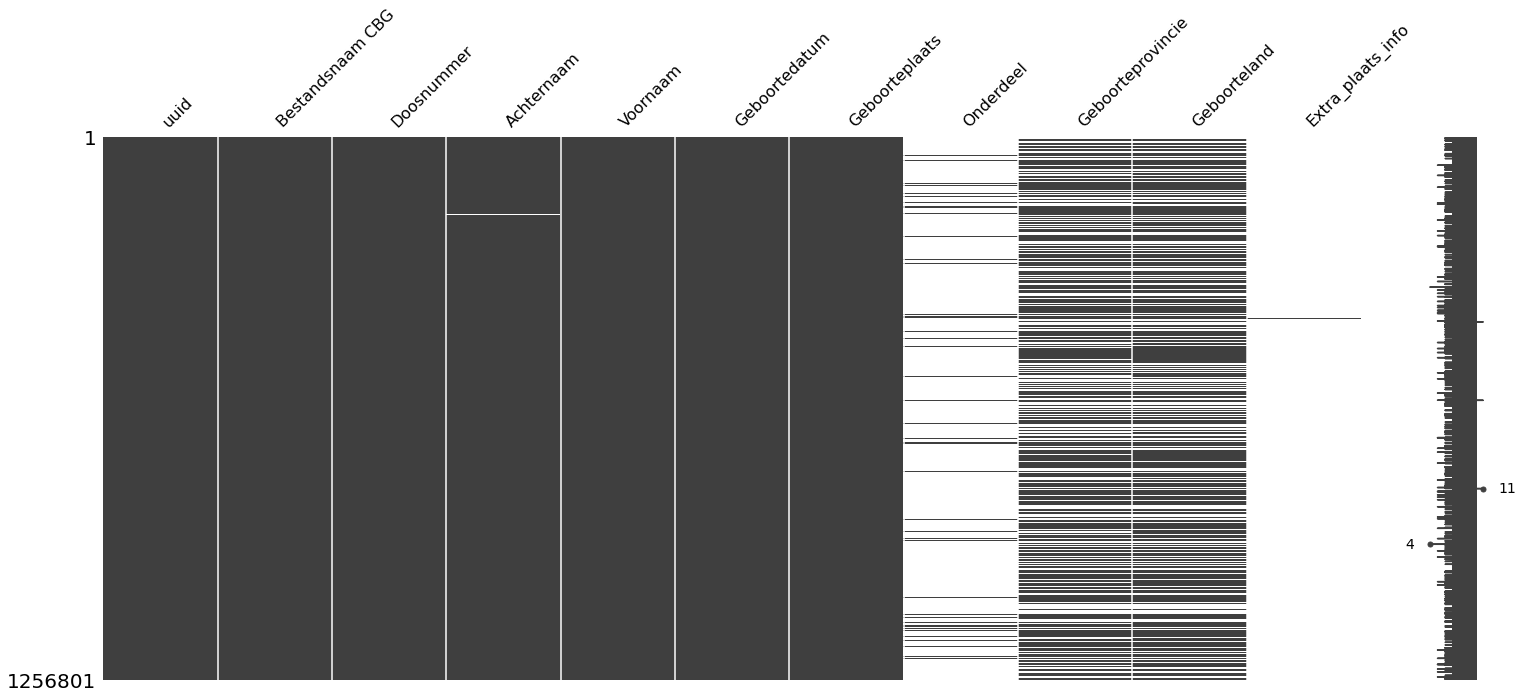

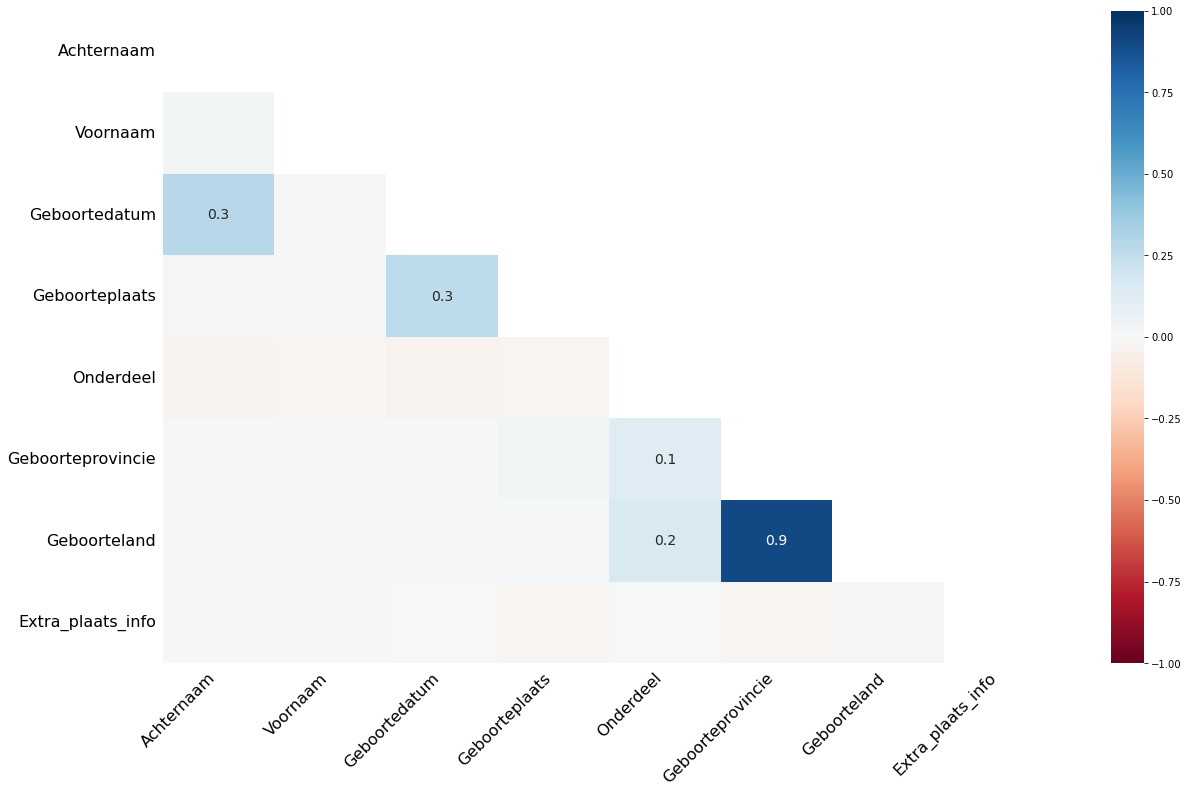

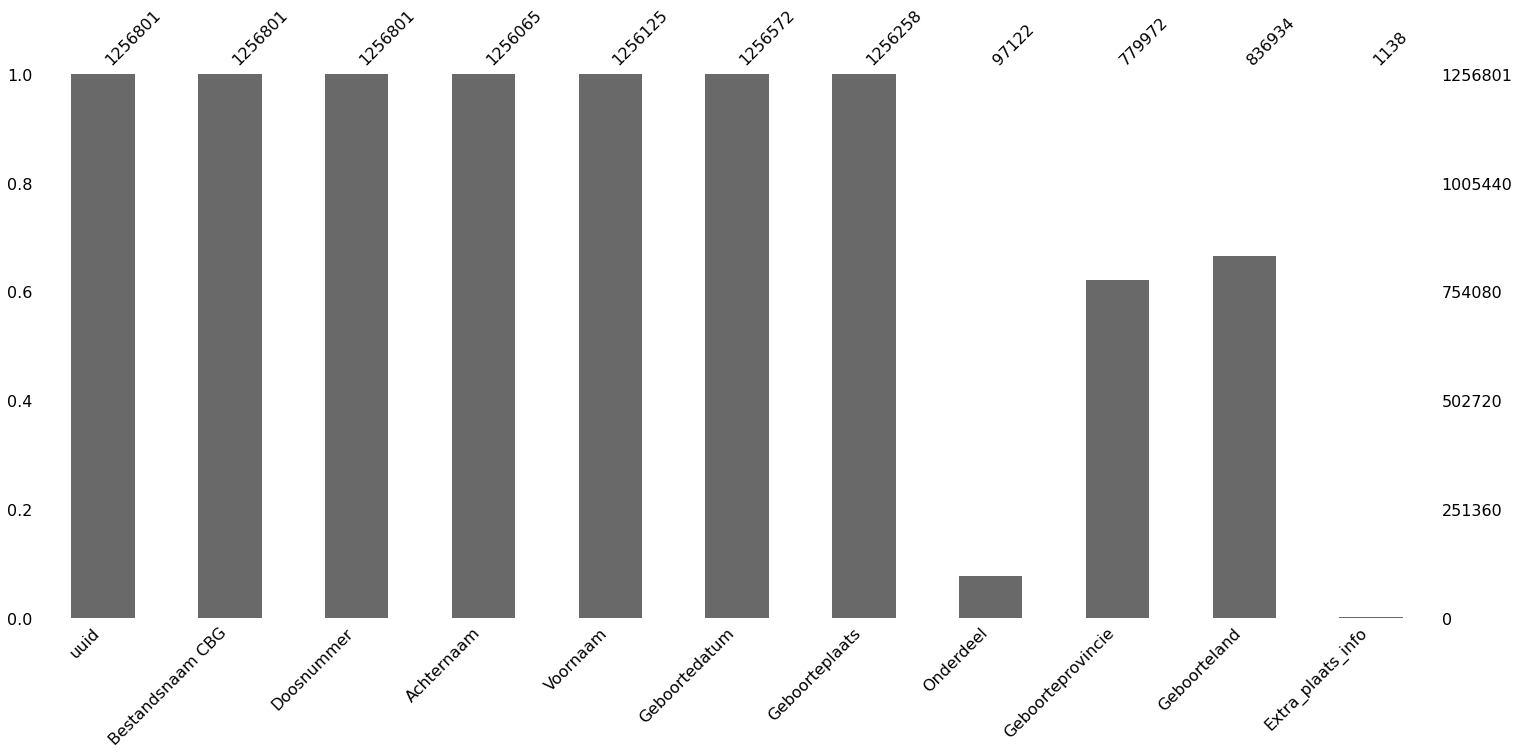

In [42]:
# Visualise final missingness patterns
visualise_missingness(df=df_person_card)

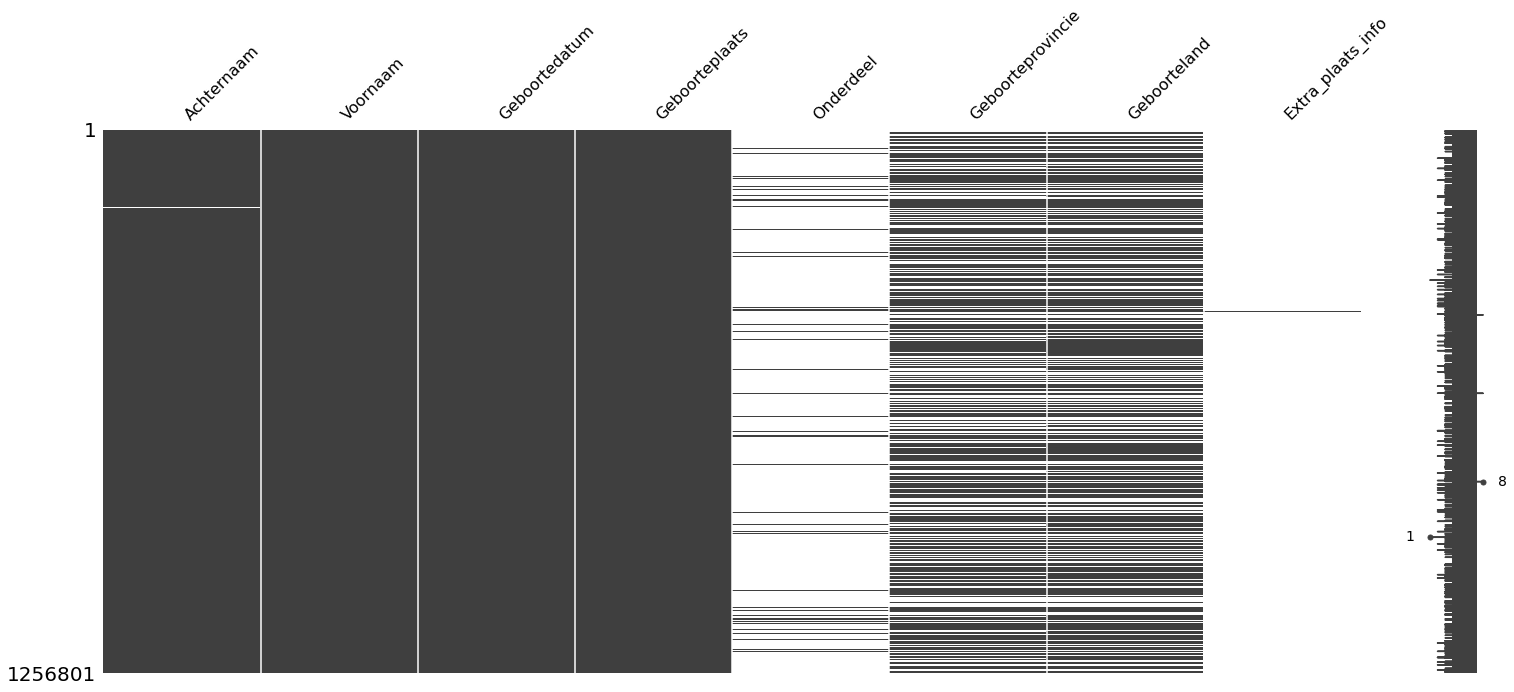

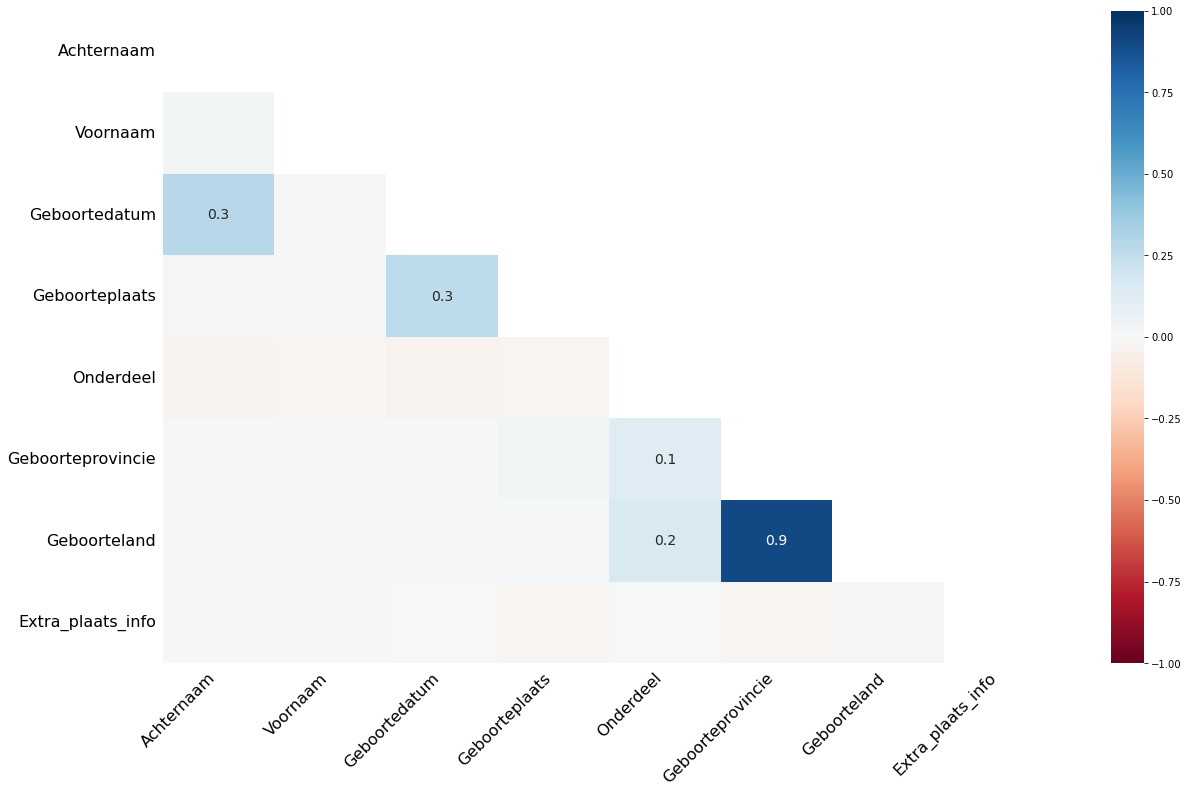

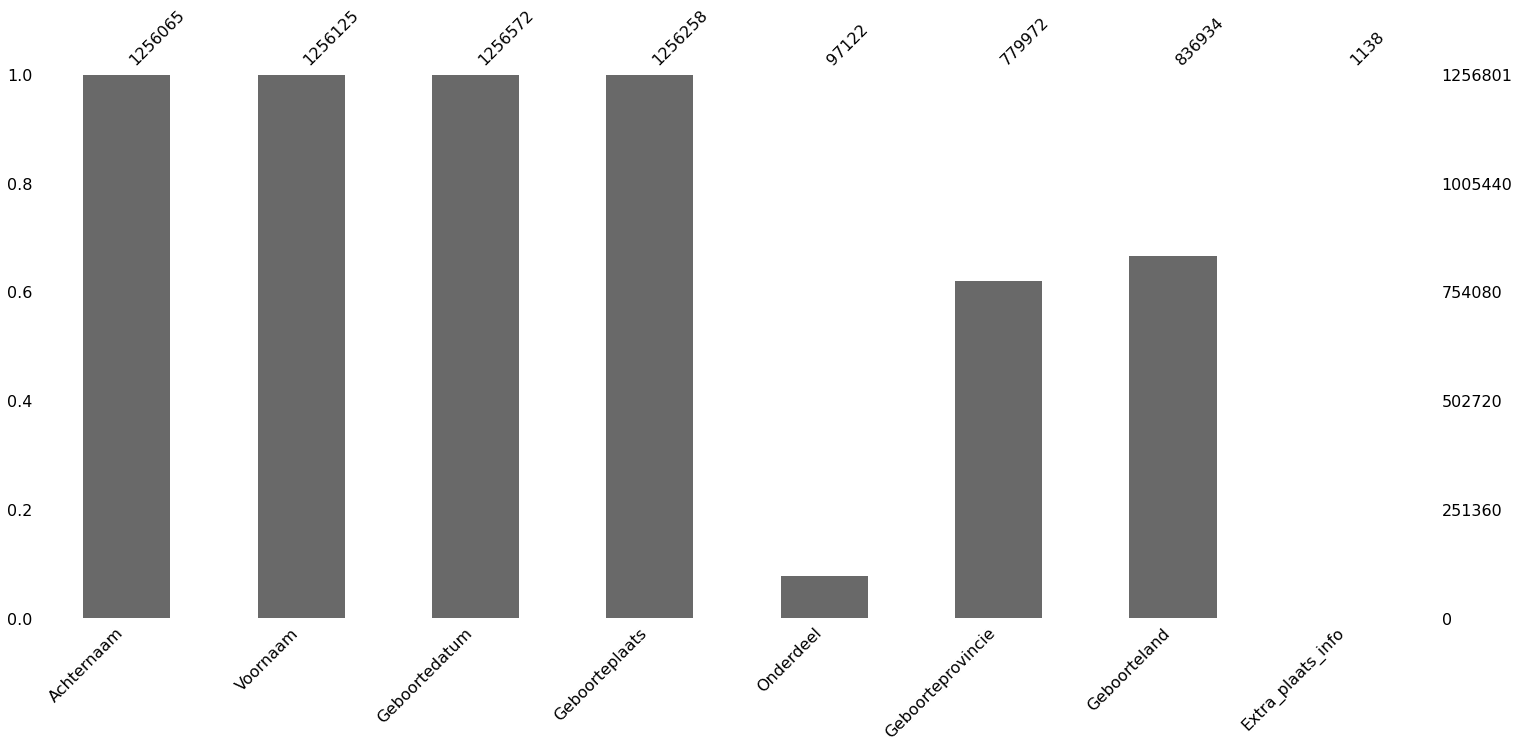

In [43]:
# Visualise final missingness pattern of only potentially used attributes in entity resolution
visualise_missingness(df=df_person_card.loc[:, df_person_card.columns.difference([
    "uuid", "Bestandsnaam CBG", "Doosnummer"], sort=False)])

In [44]:
# Check again the number of unique values in each column
df_person_card.nunique()

uuid                 1256801
Bestandsnaam CBG     1256801
Doosnummer              1559
Achternaam             66998
Voornaam              216894
Geboortedatum          50026
Geboorteplaats         17474
Onderdeel               3333
Geboorteprovincie         11
Geboorteland             149
Extra_plaats_info        317
dtype: int64

In [45]:
# Now the data is cleaned and multiple ways of writing missing values are standardised,
# Again subset the data to only keep the records that contain at least one feature 
# with noted meta data
df_person_card = df_person_card.dropna(axis=0, how='all', 
                                       subset=['Achternaam', 'Voornaam', 
                                               'Geboortedatum', 'Geboorteplaats'])

In [46]:
# Still the same number of records are maintained as before missing value standardisation
# No additional records were dropped
print("The subsetted cleaned personal record card data contains", len(df_person_card), "records")

The subsetted cleaned person card data contains  1256801  records


In [47]:
# Save the cleaned data to .csv file (without dataframe indices as new column)
clean_person_card_path = os.path.join(data_path, "clean_persoonskaarten.csv")
df_person_card.to_csv(clean_person_card_path, sep=",", header=True, index=False)

In [48]:
# Check for most common first names (as full combination of multiple names)
# Note that missing values are not included
df_person_card.Voornaam.value_counts(normalize=True).head(20)

Jan              0.021952
Johannes         0.015011
Hendrik          0.013198
Cornelis         0.013015
Willem           0.011328
Pieter           0.010625
Johanna          0.010480
Maria            0.010331
Gerrit           0.008272
Jacob            0.007085
Cornelia         0.006718
Dirk             0.005484
Elisabeth        0.005051
Grietje          0.004870
Arie             0.004800
Aaltje           0.004762
Johanna Maria    0.004557
Jacobus          0.004471
Hendrika         0.004398
Anna Maria       0.004386
Name: Voornaam, dtype: float64

In [49]:
# Check for most common last names
# Note that missing values are not included
df_person_card.Achternaam.value_counts(normalize=True).head(20)

Bakker           0.011687
van Dijk         0.010823
van den Berg     0.010785
Dekker           0.005790
Brouwer          0.005348
de Vries         0.004654
Dijkstra         0.003783
de Bruijn        0.003480
de Bruin         0.003470
de Boer          0.003342
van Beek         0.003295
Visser           0.003276
van den Broek    0.003260
van Dam          0.002910
Blom             0.002894
Smit             0.002779
Boer             0.002298
de Groot         0.002294
de Graaf         0.002259
van den Brink    0.002205
Name: Achternaam, dtype: float64

In [ ]:
# A surname like "Zonder" (without) also exists, but unclear if this is a missing value or
# just their family name (so kept it unchanged as this value was not occuring in other
# attributes so seems to not have been used as missing value indicator, and these people
# seem to be related due to corresponding birth places)
# Output cleared due to privacy-sensitive data
df_person_card[df_person_card.Achternaam == "Zonder"]

In [51]:
# Check for most common birth dates
# Note that missing values are not included
df_person_card.Geboortedatum.value_counts(normalize=True).head(20)

1900-04-01    0.000095
1896-03-01    0.000094
1896-10-03    0.000091
1895-02-24    0.000088
1899-04-09    0.000088
1901-02-02    0.000088
1897-10-16    0.000088
1899-04-02    0.000087
1905-01-22    0.000087
1896-09-27    0.000087
1895-03-24    0.000087
1898-02-21    0.000087
1901-03-22    0.000086
1895-01-01    0.000084
1897-03-06    0.000084
1896-03-06    0.000084
1899-03-17    0.000084
1898-05-06    0.000084
1894-01-07    0.000083
1895-01-27    0.000083
Name: Geboortedatum, dtype: float64

In [52]:
def date_distribution(df_dates):
    '''
    Determine temporal distribution of dates recorded in documents 
    by checking its statistics and displaying the distribution of 
    counts of records per year in a line plot
    
    df_dates : Pandas series
        Series containing dates as datetime.date objects
    '''
    # Get only the datetime.date objects (partly missing values are strings, others NaN)
    dates = df_dates[df_dates.apply(lambda x: isinstance(x, datetime.date))]

    # Make sure that dates is datetime object (partly missing values are strings, others NaN)
    # If can't do it, then will replace the date for NaT object
    dates = pd.to_datetime(dates, errors='coerce')
    # Remove NaT values 
    dates = dates.dropna(how='any')

    # Group dates by year, and determine counts of records per year
    dates_count = dates.groupby(dates.dt.year).count()

    # Determine date years statistics
    min_date = dates_count.keys().min()
    max_date = dates_count.keys().max()
    mean_date = np.mean(dates_count.keys())
    median_date = np.median(dates_count.keys())
    print("Date statistics are:")
    print("Minimum:", min_date)
    print("Maximum:", max_date)
    print("Average:", mean_date)
    print("Median:", median_date)

    # Determine the x-axis labels (the last item is exclusive so add one year)
    x_years = np.arange(min_date, max_date+1, step=10) 
    
    # Plot distribution in line plot
    fig,ax = plt.subplots()
    dates_count.plot(x_compat=True, ax=ax, ylabel='Number of records', xlabel='Birth year',
                    xticks = x_years)
    plt.xticks(rotation=90) # Rotate x-labels
    plt.show()

Date statistics are:
Minimum:  1834
Maximum:  1994
Average:  1913.0188679245282
Median:  1913.0


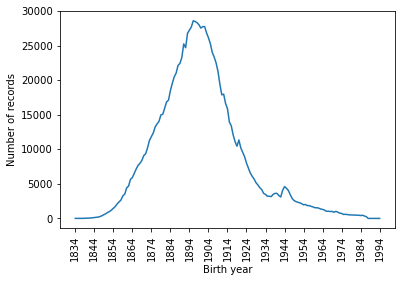

In [53]:
# Display statistics and distribution of birth dates 
# Note that (partly) missing values are not included
date_distribution(df_dates=df_person_card.Geboortedatum)

In [54]:
# Check for most common birth places
# Note that missing values are not included
df_person_card.Geboorteplaats.value_counts(normalize=True).head(20)

Amsterdam           0.070514
Rotterdam           0.052665
's-Gravenhage       0.032962
Utrecht             0.019275
Groningen           0.010501
Leiden              0.010491
Haarlem             0.010089
Arnhem              0.009832
Tilburg             0.009268
Nijmegen            0.007679
Dordrecht           0.006736
Maastricht          0.006328
Delft               0.006089
's-Hertogenbosch    0.006070
Apeldoorn           0.005703
Zwolle              0.005684
Schiedam            0.005629
Leeuwarden          0.005421
Helder              0.004962
Breda               0.004774
Name: Geboorteplaats, dtype: float64

In [55]:
# Check for frequency of Dutch birth provinces (when these are mentioned)
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_freq = df_person_card['Geboorteprovincie'].value_counts(normalize=True)
province_freq

Zuid-Holland     0.156471
Noord-Brabant    0.138005
Gelderland       0.137993
Noord-Holland    0.117259
Friesland        0.084815
Overijssel       0.078302
Limburg          0.073601
Groningen        0.067968
Zeeland          0.054676
Utrecht          0.048902
Drenthe          0.042008
Name: Geboorteprovincie, dtype: float64

In [56]:
def province_pie_chart(province_frequency):
    """
    Visualise a circle diagram that shows the frequency distribution of province names
    
    Parameters
    ----------
    province_frequency : Pandas series
        Series containing counts of each unique province value in the data
    """
    # Get the 10 default colours and add two to get 12 colours for each Dutch province
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    colors = colors + ['salmon', 'coral']

    # Create circle diagram 
    province_frequency.plot.pie(ylabel='', autopct='%1.1f%%', normalize=True, colors=colors)

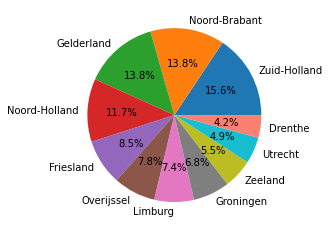

In [57]:
# Create circle diagram of Dutch province distribution
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_pie_chart(province_frequency=province_freq)

In [58]:
# Check for most common birth countries
# Note that missing values are not included
# Note that the Netherlands is partially mentioned more because that was filled in when a 
# Dutch province name indicator was found in the recorded place name, which was not inferred 
# for provinces of other countries
df_person_card['Geboorteland'].value_counts(normalize=True).head(20)                                           

Nederland                            0.903891
Duitsland                            0.028040
Nederland, Denemarken                0.015447
Nederland, Oostenrijk                0.012942
Indonesië                            0.009434
België                               0.007639
Nederland, Nederlandse Antillen      0.003314
Nederland, Ijsland                   0.003111
Oostenrijk, Nederland                0.002932
Suriname                             0.002374
Oostenrijk                           0.001368
Turkije                              0.000927
Polen                                0.000758
Frankrijk                            0.000670
Denemarken                           0.000656
Italië                               0.000589
Marokko                              0.000545
Oostenrijk, Nederland, Oostenrijk    0.000534
Hongarije                            0.000504
Nederlandse Antillen                 0.000487
Name: Geboorteland, dtype: float64

In [59]:
# Check for most common birth place additions (e.g. province in non-Dutch country that was 
# first mentioned between parentheses)
# Note that missing values are not included
df_person_card['Extra_plaats_info'].value_counts(normalize=True).head(20)

Haarlem        0.404218
W              0.188928
S              0.042179
Niederrhein    0.007030
Ambon          0.007030
Java           0.004394
Ruhr           0.004394
Saale          0.004394
Kediri         0.003515
New York       0.003515
Baden          0.003515
Ambarawa       0.002636
Celebes        0.002636
Solo           0.002636
Atjeh          0.002636
Thüringen      0.002636
Sieg           0.002636
ver            0.002636
Eindhoven      0.002636
Californië     0.002636
Name: Extra_plaats_info, dtype: float64

In [60]:
# Check for most common additional information (recorded in 'Onderdeel')
# Note that missing values are not included
df_person_card.Onderdeel.value_counts(normalize=True).head(20)

Nederlandsch-Indië    0.048279
Nederlandsch Indië    0.036356
Drachten              0.017051
Bergum                0.008958
Noordwolde            0.008247
Blerick               0.007877
Oosterbeek            0.007733
Nunspeet              0.007032
Joure                 0.006971
Lemmer                0.006651
Zwaagwesteinde        0.005992
Surhuisterveen        0.005673
Terwispel             0.005601
Haulerwijk            0.005395
Wolvega               0.005251
Sint Annaparochie     0.005117
Akkerwoude            0.005035
Stiens                0.004973
Kollum                0.004860
Makkum                0.004850
Name: Onderdeel, dtype: float64

## Inspect and clean CBG passport requests

This is the original set of passport requests of which the recorded part of the meta data is digitized by people who do not understand Dutch nor Indonesian and hence may not fully corresponds to the information recorded on its respective document. This data got exported on 10th of May 2022.

In [61]:
# Path to passport requests data
passport_path = os.path.join(data_path, "Indische_paspoorten.xlsx")

In [62]:
# Load passport requests data into a dataframe
# Because .xlsx files are not standardly supported by pandas Excel reading function anymore,
# openpyxl engine will be used for this instead
df_passport = pd.read_excel(passport_path, sheet_name=0, header=0, index_col=None, 
                            engine='openpyxl')

In [63]:
# Inspect passport request data
df_passport.columns

Index(['id', 'p1_voornaam', 'p1_voorvoegsel', 'p1_achternaam', 'p1_gebdat',
       'p1_gebplaats', 'p1_gebland', 'p1_geslacht', 'p2_voornaam',
       'p2_voorvoegsel', 'p2_achternaam', 'map1', 'map2', 'opa_image_a',
       'opa_image_b', 'opa_image_c', 'opa_image_d', 'opa_image_e',
       'opa_image_f', 'opa_image_g', 'opa_image_h', 'opa_image_i',
       'opa_image_j', 'opa_image_k', 'BaseURL', 'Link1', 'Link2', 'Link3',
       'Link4', 'Link5', 'Link6', 'Link7', 'Link8', 'Link9', 'Link10',
       'Link11', 'Link13'],
      dtype='object')

These translation/description of these columns is:
* 'id' : unique identifier of passport request at CBG
* 'p1_achternaam' : last name of key person without potential suffix
* 'p1_voorvoegsel' : last name suffix of key person
* 'p1_voornaam' : first name of key person
* 'p1_gebdat' : birth date of key person in YYYYMMDD format
* 'p1_gebplaats' : birth place name of key person
* 'p1_gebland' : birth country name of key person
* 'p1_geslacht' : registered sex of key person
* 'p2_achternaam' : last name of partner of key person without potential suffix
* 'p2_voorvoegsel' : last name suffix of partner of key person
* 'p2_voornaam' : first name of partner of key person
* Remaining features refer to images related to the key person and their relatives

In [ ]:
# Inspect passport requests data
# Output cleared due to privacy-sensitive data
df_passport.head()

In [ ]:
# Inspect all columns of one record
# Output cleared due to privacy-sensitive data
df_passport.iloc[0]

In [66]:
print("The original passport request data contains", len(df_passport), "records")

The original passport request data contains  141382  records


In [67]:
# Check how many missing values are in the columns
df_passport.isna().sum()

id                     0
p1_voornaam         1872
p1_voorvoegsel    114722
p1_achternaam          0
p1_gebdat              1
p1_gebplaats           0
p1_gebland        130426
p1_geslacht            0
p2_voornaam        47439
p2_voorvoegsel    123271
p2_achternaam      45611
map1                   0
map2                   0
opa_image_a            0
opa_image_b           10
opa_image_c       138269
opa_image_d       138311
opa_image_e       140230
opa_image_f       141038
opa_image_g       141244
opa_image_h       141330
opa_image_i       141361
opa_image_j       141376
opa_image_k       141379
BaseURL                0
Link1                  0
Link2                  0
Link3                  0
Link4                  0
Link5                  0
Link6                 10
Link7                  0
Link8                  0
Link9                  0
Link10                 0
Link11                 0
Link13                 0
dtype: int64

In [68]:
# Check types of columns
df_passport.dtypes

id                 int64
p1_voornaam       object
p1_voorvoegsel    object
p1_achternaam     object
p1_gebdat         object
p1_gebplaats      object
p1_gebland        object
p1_geslacht       object
p2_voornaam       object
p2_voorvoegsel    object
p2_achternaam     object
map1               int64
map2               int64
opa_image_a       object
opa_image_b       object
opa_image_c       object
opa_image_d       object
opa_image_e       object
opa_image_f       object
opa_image_g       object
opa_image_h       object
opa_image_i       object
opa_image_j       object
opa_image_k       object
BaseURL           object
Link1             object
Link2             object
Link3             object
Link4             object
Link5             object
Link6             object
Link7             object
Link8             object
Link9             object
Link10            object
Link11            object
Link13            object
dtype: object

In [69]:
# Check number of unique values in each column
df_passport.nunique()

id                141382
p1_voornaam        72857
p1_voorvoegsel        41
p1_achternaam      36159
p1_gebdat          26037
p1_gebplaats       21090
p1_gebland            57
p1_geslacht            4
p2_voornaam        51424
p2_voorvoegsel        42
p2_achternaam      32833
map1                  40
map2                  29
opa_image_a       141382
opa_image_b       141372
opa_image_c         3113
opa_image_d         3071
opa_image_e         1152
opa_image_f          344
opa_image_g          138
opa_image_h           52
opa_image_i           21
opa_image_j            6
opa_image_k            3
BaseURL               29
Link1             141382
Link2             141373
Link3               3114
Link4               3072
Link5               1153
Link6                345
Link7                139
Link8                 53
Link9                 22
Link10                 7
Link11                 4
Link13            138683
dtype: int64

In [70]:
# Check which value options there are for 'p1_geslacht' (registered sex) and 
# their frequency balance. Note that missing values recorded as NaN are not included
df_passport.p1_geslacht.value_counts(normalize=True)

O      0.728806
V      0.269850
M      0.001337
VVV    0.000007
Name: p1_geslacht, dtype: float64

'O' likely means 'onbekend' (unknown), 'V' vrouw (female), 'M' man (male), and 'VVV' should likely also be 'V' or refers to multiple people at once.

In [ ]:
# Check what VVV may mean: indeed seems it should just be female when assuming registered
# sex based on key person's first name
# Output cleared due to privacy-sensitive data
df_passport[df_passport.p1_geslacht == 'VVV']

In [72]:
# Replace VVV with V for registered sex
df_passport.p1_geslacht.replace(to_replace='VVV', value='V', inplace=True)

In [ ]:
# Check what O may mean: indeed seems it should just be missing value as names seem to point to
# multiple different sexes when assuming that based on key people their first names
# (instead of O being intersex for example, for which it would likely also
# occur too often in the dataset)
# Output cleared due to privacy-sensitive data
df_passport[df_passport.p1_geslacht == 'O'].head()

In [74]:
# Replace O for missing value for registered sex
df_passport.p1_geslacht.replace(to_replace='O', value=np.nan, inplace=True)

In [75]:
# Specifically in this dataset 0 indicates missing values, so are replaced with NaN
# Don't do this for the id column as one may correctly have the id=0
df_passport.loc[:, df_passport.columns != 'id'] = df_passport.loc[:, df_passport.columns != 'id'
                                                                 ].replace(to_replace=0, 
                                                                           value=np.nan, 
                                                                           inplace=False)

In [76]:
# Empty strings sometimes indicate missing values, so are replaced with NaN
df_passport.replace(to_replace='', value=np.nan, inplace=True)

In [77]:
# Like in personal record cards, additional missing values may be recorded as '####' 
# so these are replaced with NaN
df_passport.replace(to_replace='####', value=np.nan, inplace=True)

In [78]:
# Replace dates for datetime objects
df_passport.p1_gebdat = df_passport.p1_gebdat.progress_apply(
    lambda x: convert_to_datetime(date_str=str(x), sep=''))

100%|██████████████████████████████████████████████████████████████████████| 141382/141382 [00:00<00:00, 290218.49it/s]


In [79]:
# Check number of missing dates now the fully missing values are replaced by NaN
df_passport.p1_gebdat.isna().sum()

296

In [80]:
# Check number of dates that couldn't get converted into a datetime.date object
# This is likely due to partially missing values (e.g. missing month and/or day)
df_passport.p1_gebdat.progress_apply(lambda x: isinstance(x, str)).sum() 

100%|██████████████████████████████████████████████████████████████████████| 141382/141382 [00:00<00:00, 820185.57it/s]


2525

In [ ]:
# Check some of the partially missing values
# Output cleared due to privacy-sensitive data
df_passport[df_passport.p1_gebdat.progress_apply(lambda x: isinstance(x, str))].head()

In [82]:
# Clean place names and separate these from province and country indicator or added info
# between parentheses, and replace abbreviations for full names
place_passport, extra_passport, province_passport, country_passport = \
clean_separate_place_province(
    df_places=df_passport.p1_gebplaats, 
    province_abbreviations=province_abbreviations, 
    place_abbreviations=place_abbreviations,
    country_abbreviations=country_abbreviations)

100%|██████████████████████████████████████████████████████████████████████| 141382/141382 [00:00<00:00, 174040.13it/s]


In [83]:
# Add column with full province names
df_passport['p1_gebprovincie'] = province_passport 

In [84]:
# Replace birth place strings for cleaned one without province and country indicators,
# or additional information between parentheses
df_passport['p1_gebplaats'] = place_passport

In [85]:
# Add column with additional place information from parentheses
df_passport['p1_gebplaats_extra_info'] = extra_passport 

In [86]:
# Add newly found countries to birth country column
df_passport['p1_gebland'] = merge_lists(list_1=df_passport['p1_gebland'], list_2=country_passport)

In [87]:
# Empty strings sometimes indicate missing values, so are replaced with NaN
# Here done again for birth place as may have become empty string now
df_passport.p1_gebplaats.replace(to_replace='', value=np.nan, inplace=True)

In [88]:
# Check which value options there are for 'p1_gebland' (birth country) and 
# their frequency balance. Note that missing values are not included
df_passport.p1_gebland.value_counts(normalize=True)

Nederland               0.606698
Denemarken              0.173452
Indonesië               0.152106
Nederlandse Antillen    0.013613
Oostenrijk              0.011312
                          ...   
China                   0.000064
Noorwegen               0.000064
Indenesië               0.000064
Verenigde Staten        0.000064
West Java               0.000064
Name: p1_gebland, Length: 85, dtype: float64

Notice that multiple name variants of Indonesia exist in this list of birth countries, including names of subparts. These should be changed for one common identifier that is useful for querying the place URI. 

In [89]:
# Replace all other name variants of (historic) Indonesia and its subparts (mostly islands) 
# for Indonesië (the Dutch country name because the place names are also Dutch variants)
# Still, most already have the correct Dutch standard name of Netherlands or Indonesia 
# (only some have a name alternative or even other country)
# Notes: Borneo is not fully part of Indonesia but still rewritten as such due to Dutch 
# relations with that country and these passport requests make it most likely to be the 
# Indonesia area. Further, Cornelis is old name of (D)jatinegara, and some other name alternatives
# are also placed next to each other in the list below
Indonesia_alternatives = ["Sumatra", "Sumatra's Westkust", "Medan Sumatra Oostkust", "West Java",
                          "Java", "Celebes", "Menado (Celebes)", "Minohassa", "Ambon", "Ambonia", 
                          "Amboina", "Timor", "Borneo", "Atjeh", "Nederlands-Indië", "Molukken", 
                          "Z. Molukken", "Menado", "Java Indonesië", "Cornelis (Djatinegara)", 
                          "Cornelis", "Wlingi", "Bali", "Flores", "Woeloe Loemadjang", 
                          "Indenesië", "Oost-Indonesië", "Tapanuli", "Wlingi-Blitar", 
                          "Lombok", "Amahei"]

df_passport.p1_gebland.replace(to_replace=Indonesia_alternatives, value="Indonesië", inplace=True)

In [90]:
# Replace 'Siam' and 'Siam (Thailand)' for the new country (Dutch) name Thailand
df_passport.p1_gebland.replace(to_replace=["Siam", "Siam (Thailand)"], value="Thailand", 
                               inplace=True)

In [91]:
# Replace Elzas-Lotharingen for the current (Dutch) country name Frankrijk it is part of
df_passport.p1_gebland.replace(to_replace="Elzas-Lotharingen", value="Frankrijk", 
                               inplace=True)

In [92]:
# Replace Brits-Indië for (Dutch) name India it is mostly currently covering
df_passport.p1_gebland.replace(to_replace="Brits-Indië", value="India", inplace=True)

In [93]:
# Replace Mddlsx for (Dutch) name Jamaica (likely refers to county of Middlesex in that island)
df_passport.p1_gebland.replace(to_replace="Mddlsx", value="Jamaica", inplace=True)

In [94]:
# Replace 'op zee' for missing value as is not part of a country
df_passport.p1_gebland.replace(to_replace="op zee", value=np.nan, inplace=True)

## Explore CBG passport requests

In [95]:
# Check frequency balance again of 'p1_gebland' (birth country). 
# Note that missing values are not included
df_passport.p1_gebland.value_counts(normalize=True)

Nederland                           0.606737
Denemarken                          0.173463
Indonesië                           0.159146
Nederlandse Antillen                0.013614
Oostenrijk                          0.011313
Singapore                           0.008756
Nederland, Denemarken               0.005113
Syrië                               0.004730
België                              0.003963
Duitsland                           0.003196
Ijsland                             0.002557
Nederland, Oostenrijk               0.000831
Saoedi-Arabië                       0.000639
Suriname                            0.000511
Verenigde Arabische Republiek       0.000447
Thailand                            0.000383
Australië                           0.000320
Senegal                             0.000320
Nederland, Ijsland                  0.000320
Ierland                             0.000256
Soedan                              0.000256
Verenigd Koninkrijk                 0.000192
Joegoslavi

In [ ]:
# Inspect cleaned data again
# Output cleared due to privacy-sensitive data
df_passport.head()

In [97]:
# Check again how many missing values are in the columns
# There is no missing value in p1_achternaam (last name), so no need to drop full records
# as there is always some information to match on
df_passport.isna().sum()

id                              0
p1_voornaam                  1872
p1_voorvoegsel             114722
p1_achternaam                   0
p1_gebdat                     296
p1_gebplaats                  421
p1_gebland                 125736
p1_geslacht                103040
p2_voornaam                 47439
p2_voorvoegsel             123271
p2_achternaam               45611
map1                            0
map2                            0
opa_image_a                     0
opa_image_b                    10
opa_image_c                138269
opa_image_d                138311
opa_image_e                140230
opa_image_f                141038
opa_image_g                141244
opa_image_h                141330
opa_image_i                141361
opa_image_j                141376
opa_image_k                141379
BaseURL                         0
Link1                           0
Link2                          10
Link3                      138269
Link4                      138311
Link5         

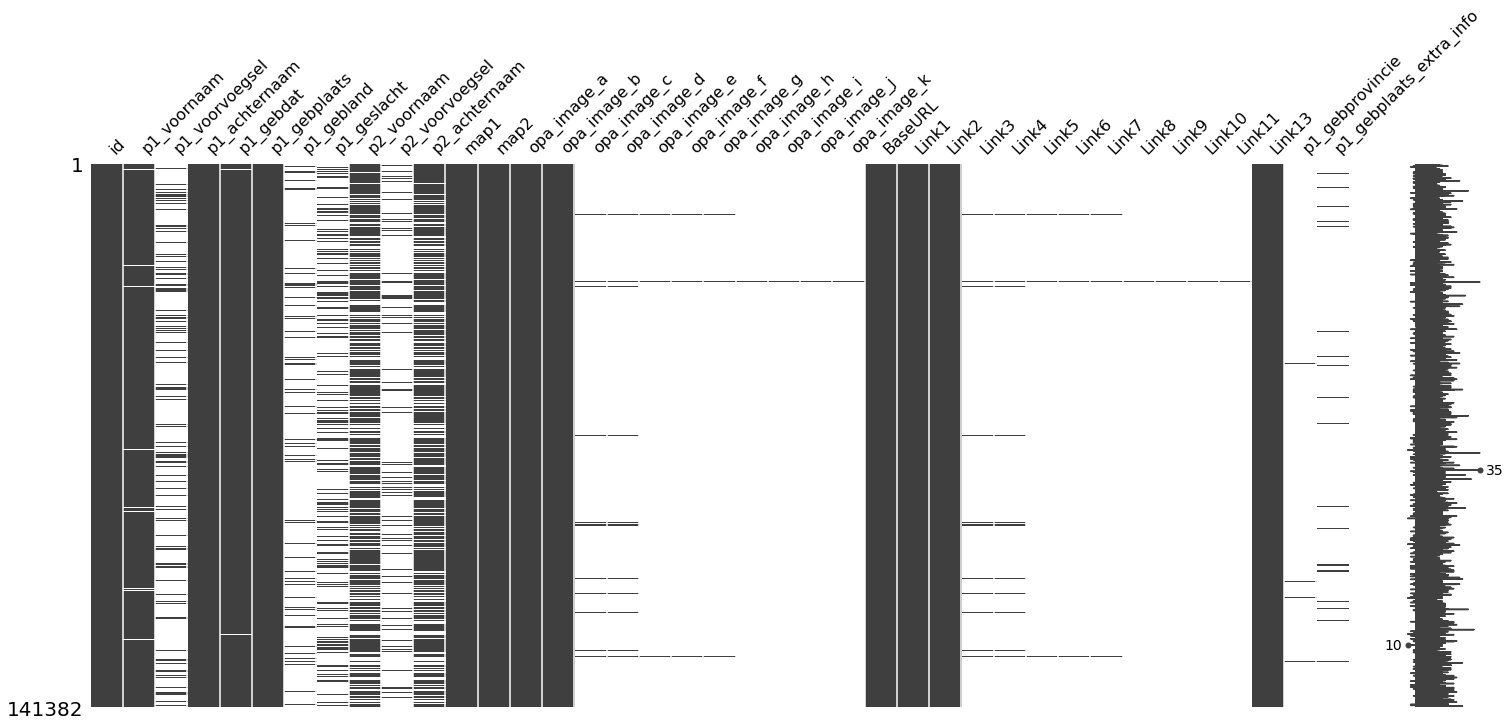

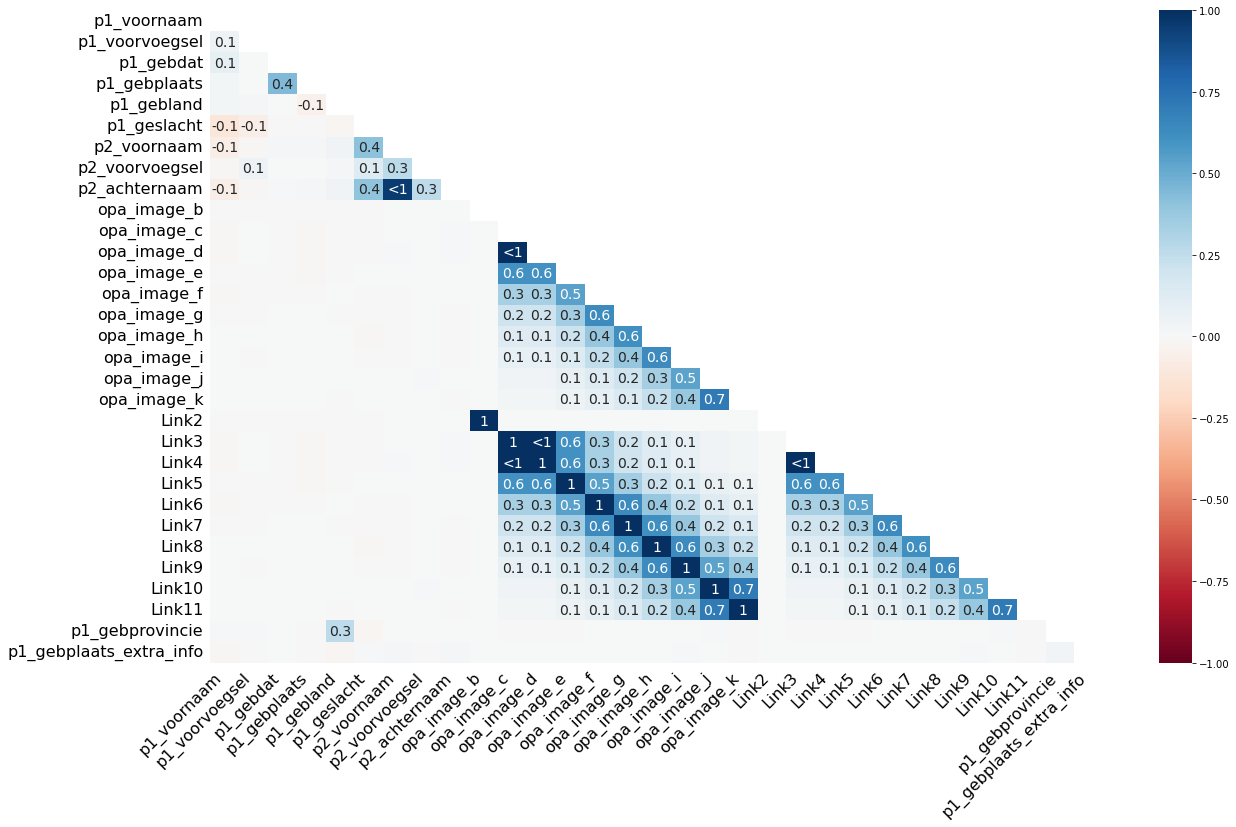

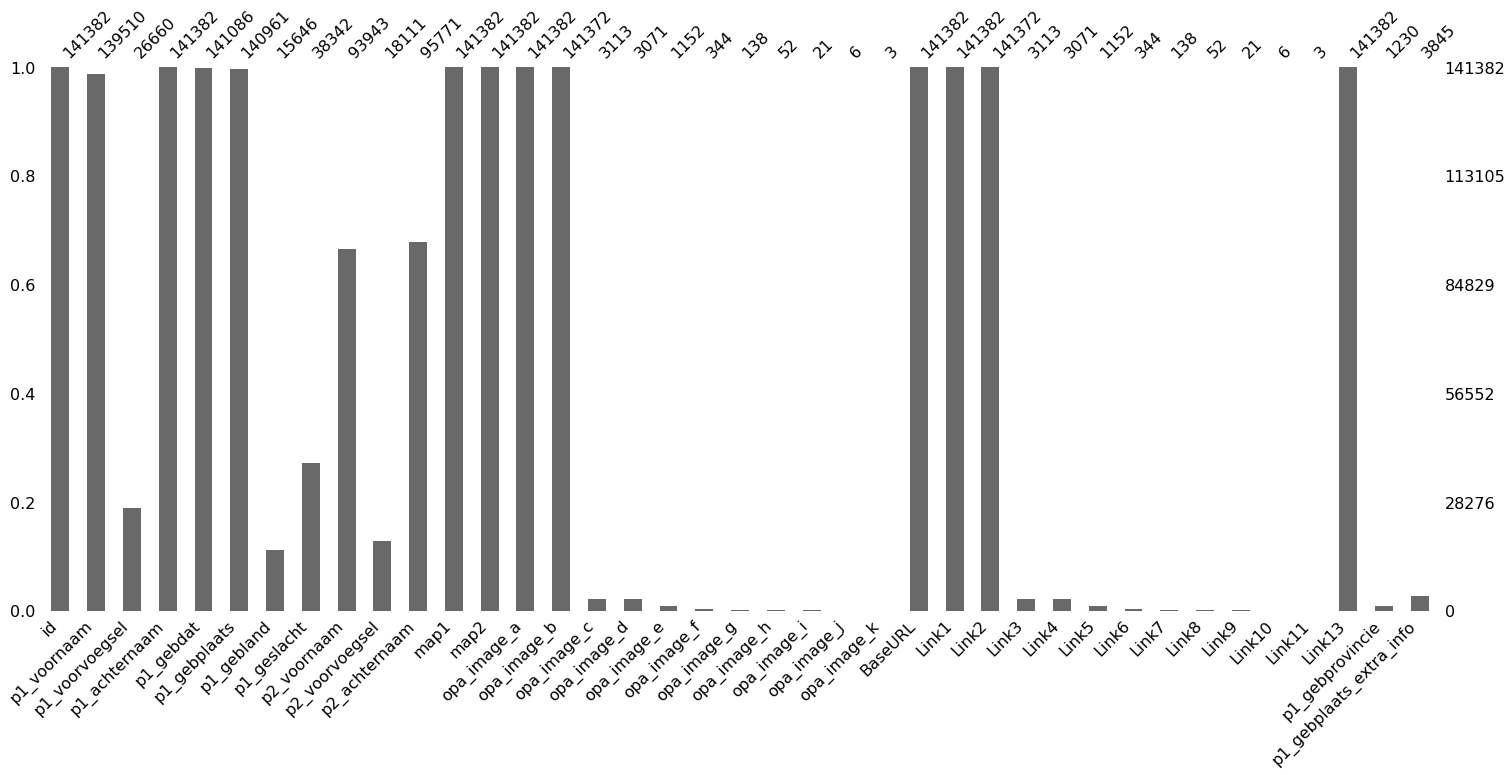

In [98]:
# Visualise final missingness patterns
visualise_missingness(df=df_passport)

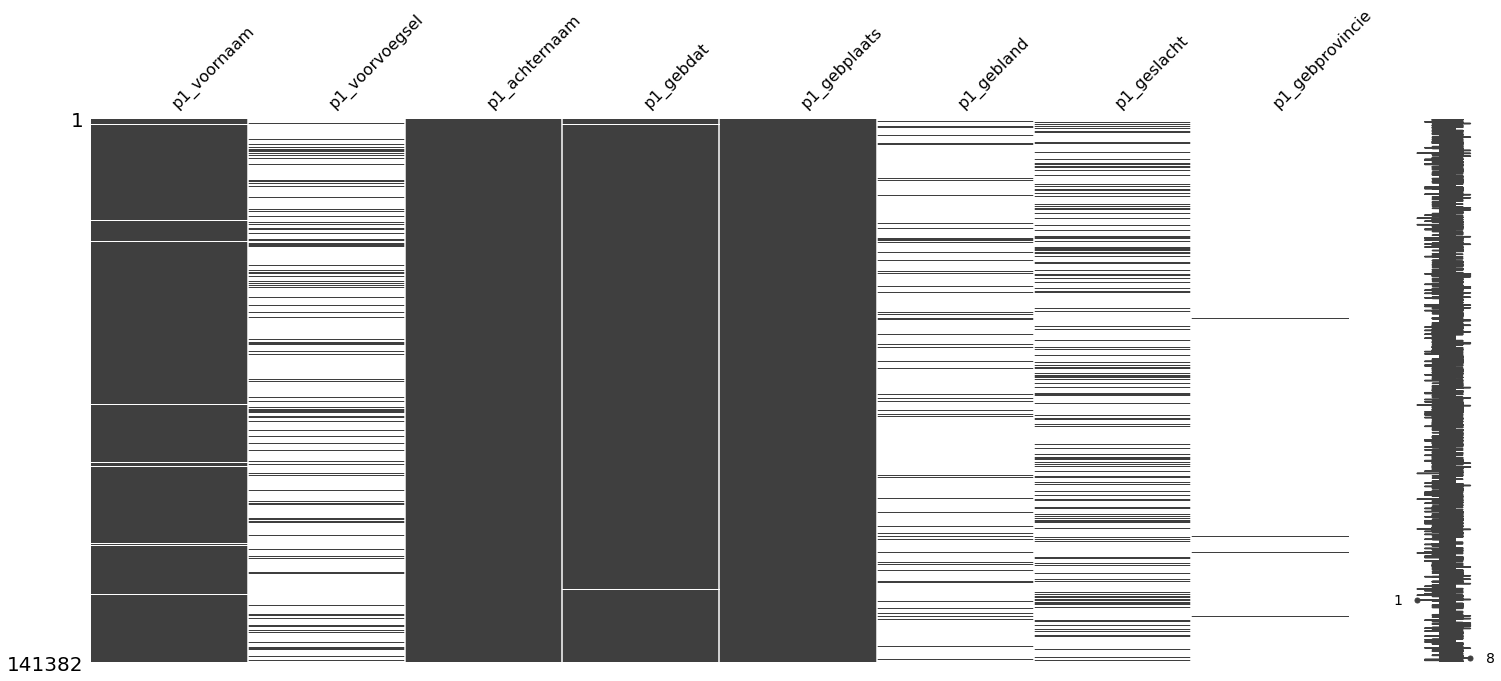

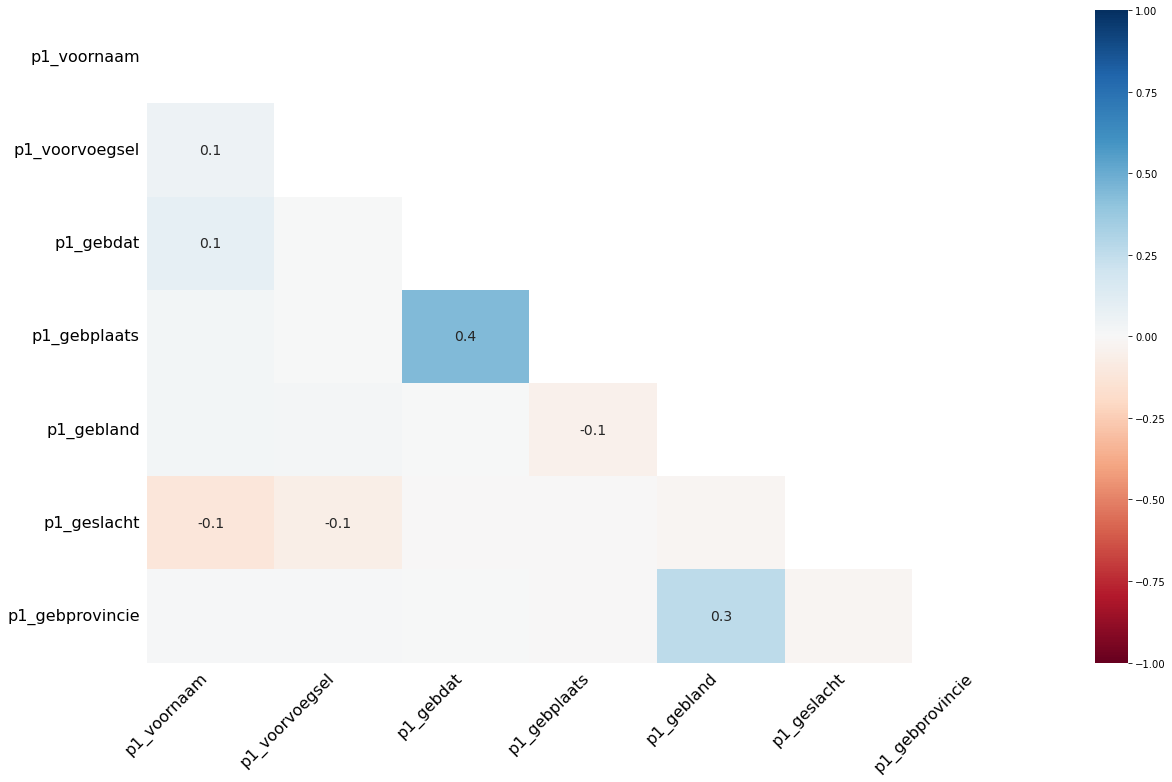

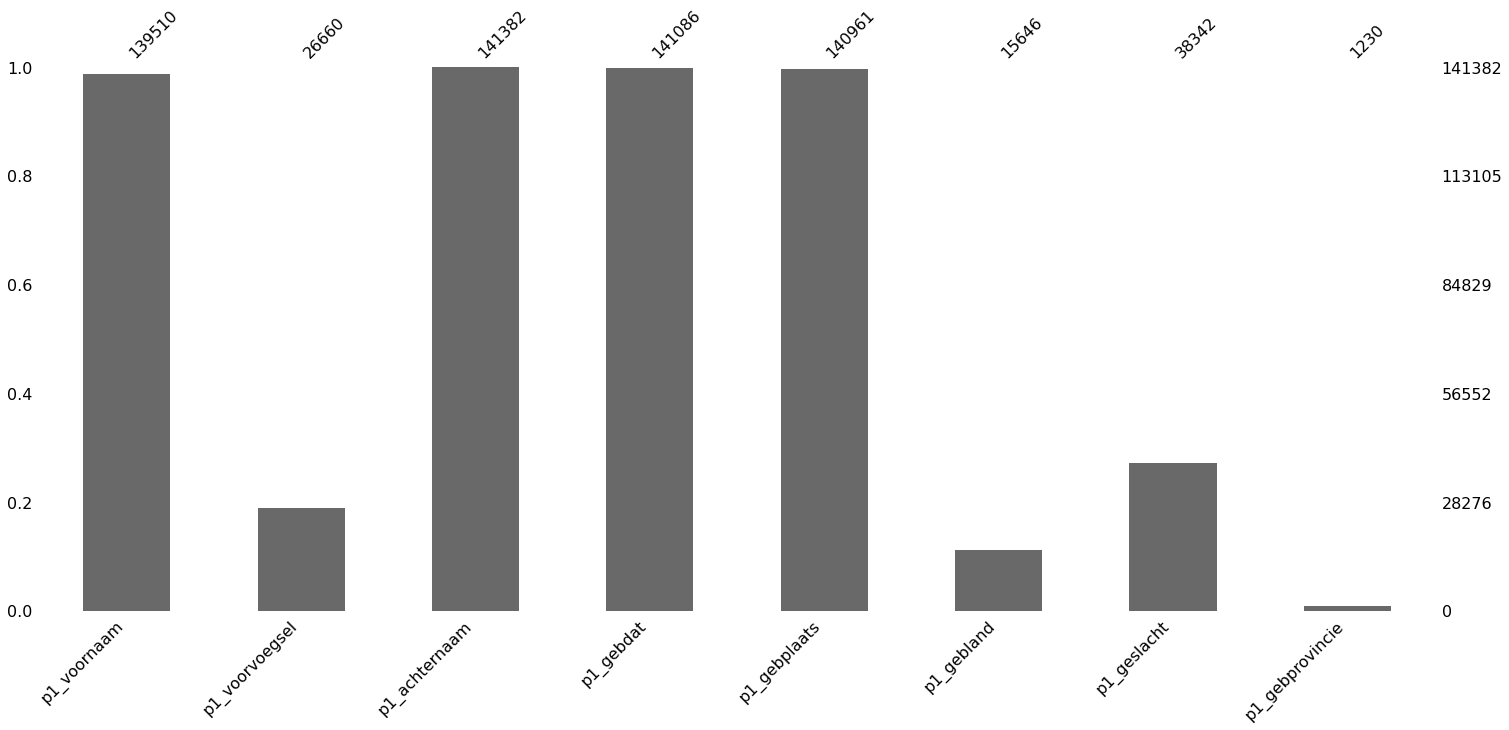

In [99]:
# Visualise final missingness pattern of only potentially used attributes in entity resolution
visualise_missingness(df=df_passport[["p1_voornaam", "p1_voorvoegsel", "p1_achternaam", 
                                             "p1_gebdat", "p1_gebplaats", "p1_gebland", 
                                             "p1_geslacht", "p1_gebprovincie"]])

In [100]:
# Check again number of unique values in each column
df_passport.nunique()

id                         141382
p1_voornaam                 72857
p1_voorvoegsel                 41
p1_achternaam               36159
p1_gebdat                   26032
p1_gebplaats                18888
p1_gebland                     52
p1_geslacht                     2
p2_voornaam                 51424
p2_voorvoegsel                 42
p2_achternaam               32833
map1                           40
map2                           29
opa_image_a                141382
opa_image_b                141372
opa_image_c                  3113
opa_image_d                  3071
opa_image_e                  1152
opa_image_f                   344
opa_image_g                   138
opa_image_h                    52
opa_image_i                    21
opa_image_j                     6
opa_image_k                     3
BaseURL                        29
Link1                      141382
Link2                      141372
Link3                        3113
Link4                        3071
Link5         

In [101]:
# Now the data is cleaned and multiple ways of writing missing values are standardised,
# subset the data to only keep the records that contain at least one feature 
# with noted meta data
df_passport = df_passport.dropna(axis=0, how='all', 
                                       subset=['p1_voornaam', 'p1_voorvoegsel', 
                                               'p1_achternaam', 'p1_gebdat', 'p1_gebplaats'])

In [102]:
# No fully missing records exist, so nothing dropped after cleaning
print("The cleaned passport request data contains", len(df_passport), "records")

The cleaned passport request data contains  141382  records


In [103]:
# Save the cleaned data to .csv file (without indices as new column)
clean_passport_path = os.path.join(data_path, "clean_Indische_paspoorten.csv")
df_passport.to_csv(clean_passport_path, sep=",", header=True, index=False)

In [104]:
# Check for most common first names (as full combination of multiple names)
# Note that missing values are not included
df_passport.p1_voornaam.value_counts(normalize=True).head(20)

Jan              0.008910
Willem           0.006623
Johannes         0.005842
Hendrik          0.005111
Cornelis         0.004616
Johanna          0.004516
Maria            0.003993
Pieter           0.003978
Elisabeth        0.002946
Johan            0.002752
Anna             0.002631
Jacob            0.002588
Marie            0.002494
Cornelia         0.002358
Gerrit           0.002337
Dirk             0.002150
Wilhelmina       0.002115
Willy            0.002093
Louise           0.001943
Johanna Maria    0.001778
Name: p1_voornaam, dtype: float64

In [105]:
# Check which value options there are for 'p1_voorvoegsel' (middle name) and 
# their frequency balance. Note that missing values are not included
# All middle names seem unique indeed (multiple languages so that made it many), 
# so nothing to replace ('v.d.' is unknown for example
# if it would need to be replaced by 'van de' or some other variant)
df_passport.p1_voorvoegsel.value_counts(normalize=True)

van           0.457389
de            0.239872
van der       0.150600
van den       0.051388
van de        0.023256
von           0.017704
den           0.012153
de la         0.009602
ten           0.006302
ter           0.005401
le            0.004989
v.d.          0.004501
van 't        0.003113
du            0.002513
d'            0.002138
la            0.002138
da            0.001875
te            0.001500
't            0.001013
in 't         0.000675
der           0.000338
op 't         0.000188
op de         0.000188
von der       0.000113
uit de        0.000113
des           0.000113
di            0.000113
aan de        0.000113
bin           0.000075
l'            0.000075
de l'         0.000075
bij de        0.000038
de van der    0.000038
da la         0.000038
auf der       0.000038
op den        0.000038
over de       0.000038
in den        0.000038
d             0.000038
voor de       0.000038
von de        0.000038
Name: p1_voorvoegsel, dtype: float64

In [106]:
# Check for most common last names
# Note that missing values are not included
df_passport.p1_achternaam.value_counts(normalize=True).head(20)

Jansen     0.003996
Jong       0.003190
Muller     0.003077
Meijer     0.002829
Berg       0.002681
Smith      0.002575
Portier    0.002483
Smit       0.002476
Meyer      0.002398
Groot      0.002214
Visser     0.001973
Simon      0.001945
Bakker     0.001931
Brouwer    0.001903
Jacobs     0.001846
Mulder     0.001811
Boer       0.001648
Leeuwen    0.001591
Pieters    0.001535
Janssen    0.001507
Name: p1_achternaam, dtype: float64

In [107]:
# Check for most common birth dates
# Note that missing values are not included
df_passport.p1_gebdat.value_counts(normalize=True).head(20)

1900-00-00    0.000744
1896-00-00    0.000489
1895-00-00    0.000461
1894-00-00    0.000418
1905-00-00    0.000418
1893-00-00    0.000411
1890-00-00    0.000404
1906-00-00    0.000404
1897-00-00    0.000383
1892-00-00    0.000369
1891-00-00    0.000340
1901-00-00    0.000333
1899-00-00    0.000333
1912-00-00    0.000326
1898-00-00    0.000326
1887-00-00    0.000312
1902-00-00    0.000305
1888-00-00    0.000276
1910-00-00    0.000276
1909-00-00    0.000255
Name: p1_gebdat, dtype: float64

Date statistics are:
Minimum:  1718
Maximum:  1998
Average:  1899.1862068965518
Median:  1901.0


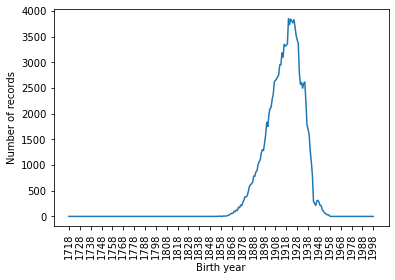

In [108]:
# Display statistics and distribution of birth dates 
# Note that (partly) missing values are not included
date_distribution(df_dates=df_passport.p1_gebdat)

In [109]:
# Check for most common birth places
# Note that missing values are not included
# Note that some places have multiple spelling variations like Soerabaja
df_passport.p1_gebplaats.value_counts(normalize=True).head(20)

Djakarta         0.057065
Amsterdam        0.043388
Semarang         0.039671
Rotterdam        0.029051
Batavia          0.028377
Soerabaia        0.024702
Surabaia         0.021964
Bandung          0.021361
Malang           0.019488
's-Gravenhage    0.014926
Bandoeng         0.014153
Haag             0.013975
Padang           0.010868
Buitenorg        0.010201
Magelang         0.010187
Utrecht          0.008889
Tjimahi          0.008676
Surabaja         0.008655
Soerabaja        0.008648
Medan            0.007094
Name: p1_gebplaats, dtype: float64

In [110]:
# Check for most common Dutch birth provinces
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_freq_passport = df_passport.p1_gebprovincie.value_counts(normalize=True).head(20)
province_freq_passport  

Overijssel       0.164228
Noord-Holland    0.130894
Friesland        0.123577
Noord-Brabant    0.108943
Limburg          0.106504
Gelderland       0.103252
Zuid-Holland     0.091057
Drenthe          0.078049
Zeeland          0.040650
Groningen        0.032520
Utrecht          0.020325
Name: p1_gebprovincie, dtype: float64

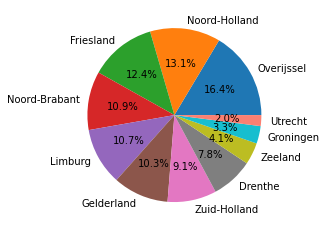

In [111]:
# Create circle diagram of Dutch province distribution
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_pie_chart(province_frequency=province_freq_passport)

In [112]:
# Check for most common birth place additional information previously recorded between 
# parentheses (e.g. provinces in non-Dutch countries)
# Note that missing values are not included
df_passport['p1_gebplaats_extra_info'].value_counts(normalize=True).head(20)

Kediri        0.047854
Djakarta      0.045774
Java          0.038231
Atjeh         0.029909
Malang        0.026788
Solo          0.021586
Bogor         0.016905
Sumatra       0.015865
Semarang      0.014564
Tegal         0.014304
Buitenorg     0.012484
Kendal        0.011443
Celebes       0.011443
Blitar        0.011183
Cheribon      0.008583
Menado        0.008322
Soerakarta    0.008322
Banka         0.008062
Djombang      0.007022
GD            0.006762
Name: p1_gebplaats_extra_info, dtype: float64